## Data Ingestion - Yahoo Finance

Ingest a list of the top 100 tech stocks traded on the NYSE by Market Cap

In [36]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

def split_name_ticker(full_name):
    match = re.search(r'(.+?)([A-Z]{2,4}|[A-Z0-9]{1,5}\.[A-Z]{1,3}|[A-Z0-9]{1,2}\.[A-Z]{1,2}\.[A-Z]{1,3}|[0-9]{4}\.[A-Z]{1,3})(?=\s|$)', full_name)
    if match:
        return match.group(1).strip(), match.group(2).strip()
    else:
        return full_name, ''

url_list = ['https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/', 
            'https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/?page=2', 
            'https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/?page=3']

dfs = []
for url in url_list:
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        rows = soup.select('tbody > .rank-td')
        data = []
        for row in rows:
            rank = row.get_text(strip=True)
            full_name = row.find_next_sibling('td', class_='name-td').get_text(strip=True)
            name, ticker = split_name_ticker(full_name)
            market_cap = row.find_next_sibling('td', class_='td-right').get_text(strip=True)
            data.append([rank, name, ticker, market_cap])
        
        df = pd.DataFrame(data, columns=['Rank', 'Name', 'Ticker', 'Market Cap'])
        dfs.append(df)
    else:
        print('Failed to retrieve the webpage. Status code:', response.status_code)

combined_df = pd.concat(dfs, ignore_index=True)

In [37]:
ticker_list = combined_df['Ticker'].tolist()
print(f"# of tickers: {len(ticker_list)}")
print(ticker_list)

# of tickers: 300
['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA', 'CTSM', 'AVGO', 'CEHY', '05930.KS', 'ORCL', 'ADBE', 'ASML', 'CSCO', 'BABA', 'CRM', 'NFLX', 'DAMD', 'PSAP', 'INTC', 'INTU', 'PDD', 'MIBM', 'TXN', 'QCOM', 'NOW', 'AMAT', 'SONY', 'BKNG', '6861.T', 'UBER', 'ADP', 'SU.PA', '3690.HK', 'LRCX', 'ADI', 'PANW', 'MU', 'SHOP', 'ABNB', 'SNPS', 'EQIX', 'NTES', 'FI', 'MELI', '00660.KS', 'KLAC', 'CDNS', 'ANET', '8035.T', 'VMW', 'PYPL', 'WDAY', 'DSY.PA', 'ARM', 'ROP', 'DELL', '7974.T', 'IACF', 'SNOW', 'TEAM', 'XP', 'FTNT', 'CSU.TO', 'CRWD', '2454.TW', 'ADSK', 'MRVL', '2317.TW', 'JD', 'MCHP', 'IFX.DE', 'TEL', 'PLTR', 'BIDU', 'TTD', 'STM', '6981.T', 'AIQV', 'EA', 'DASH', 'C0981.HK', 'SPOT', 'WKL.AS', 'VEEV', 'FIS', 'CSGP', 'CPNG', 'MBLY', 'DELTA.BK', 'GPN', 'ON', '1024.HK', 'GFS', 'SQ', 'PHPQ', 'IT', 'DDOG', '6723.T', 'SPLK', '2308.TW', '7751.T', 'ANSS', 'SE', 'BMDB', 'ZS', 'TTWO', 'MPWR', 'FICO', 'ADYEN.AS', 'GRMN', 'KEYS', '35420.KS', 'TCOM', 'SM', 'HUBS', '6752.T', 'SYM', 'EBAY

In [46]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, DateType, IntegerType
import yfinance as yf
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder \
    .appName("StockDataIngestion") \
    .config("spark.driver.memory", "5g") \
    .config("spark.executor.memory", "5g") \
    .getOrCreate()

# Define schema for PySpark DataFrame
schema = StructType([
    StructField('Date', DateType(), True),
    StructField('Open', FloatType(), True),
    StructField('High', FloatType(), True),
    StructField('Low', FloatType(), True),
    StructField('Close', FloatType(), True),
    StructField('Adj Close', FloatType(), True),
    StructField('Volume', IntegerType(), True),
    StructField('Ticker', StringType(), True),
])

# Placeholder for PySpark DataFrames
dfs = []

for ticker in ticker_list:
    try:
        print(f"Fetching data for {ticker}")
        stock_data = yf.download(ticker, period="max", timeout=120)
        if not stock_data.empty:
            # Fetch last 1000 days of daily stock data using yfinance
            stock_data = yf.download(ticker, period="max")
            
            if not stock_data.empty:
                # Reset index to get 'Date' in columns
                stock_data.reset_index(inplace=True)
                
                # Add a 'Ticker' column
                stock_data['Ticker'] = ticker
                
                # Convert to PySpark DataFrame using the predefined schema
                stock_data_spark = spark.createDataFrame(stock_data, schema=schema)
                
                dfs.append(stock_data_spark)
            else:
                print(f"No data found for {ticker}")
        else:
            print(f"No data found for {ticker}")
    except ValueError as e:
        print(f"An error occurred for ticker {ticker}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred for ticker {ticker}: {e}")

# Union all individual dataframes to create a single PySpark DataFrame
final_df = None
if dfs:
    final_df = dfs[0]
    for df in dfs[1:]:
        final_df = final_df.union(df)

    final_df.show()
else:
    print("No dataframes to union")

Fetching data for AAPL
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
An error occurred for ticker AAPL: [VALUE_OUT_OF_BOUND] Value for `obj` must be greater than 2147483647 or less than -2147483648, got 2832345600
Fetching data for MSFT
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for GOOG
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for AMZN
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for NVDA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for META
[*********************100%%


1 Failed download:
['CTSM']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1924-11-26 -> 2023-11-02)')



No data found for CTSM
Fetching data for AVGO
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for CEHY
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['CEHY']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for CEHY
Fetching data for 05930.KS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['05930.KS']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for 05930.KS
Fetching data for ORCL
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for ADBE
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for ASML
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for CSCO
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for BABA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for CRM
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetchin


1 Failed download:
['DAMD']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for DAMD
Fetching data for PSAP
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PSAP']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for PSAP
Fetching data for INTC
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for INTU
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for PDD
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for MIBM
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MIBM']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for MIBM
Fetching data for TXN
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for QCOM
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for NOW
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for AMAT
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for SONY
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for BKNG
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching dat


1 Failed download:
['00660.KS']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for 00660.KS
Fetching data for KLAC
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for CDNS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for ANET
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 8035.T
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for VMW
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for PYPL
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetch


1 Failed download:
['IACF']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for IACF
Fetching data for SNOW
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for TEAM
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for XP
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for FTNT
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for CSU.TO
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for CRWD
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching d


1 Failed download:
['AIQV']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for AIQV
Fetching data for EA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for DASH
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for C0981.HK
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['C0981.HK']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for C0981.HK
Fetching data for SPOT
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for WKL.AS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for VEEV
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for FIS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for CSGP
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for CPNG
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetch


1 Failed download:
['PHPQ']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for PHPQ
Fetching data for IT
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for DDOG
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 6723.T
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for SPLK
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 2308.TW
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
An error occurred for ticker 2308.TW: [VALUE_OUT_OF_BOUND] Value for `obj` must be greater than 2147483647 or less than -2147483648, got 6929166184
Fetching data for 77


1 Failed download:
['BMDB']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for BMDB
Fetching data for ZS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for TTWO
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for MPWR
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for FICO
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for ADYEN.AS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for GRMN
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching


1 Failed download:
['35420.KS']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for 35420.KS
Fetching data for TCOM
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for SM
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for HUBS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 6752.T
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for SYM
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for EBAY
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetchin


1 Failed download:
['CPTC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1924-11-26 -> 2023-11-02)')



No data found for CPTC
Fetching data for SNAP
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for TYL
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for SE
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for FDS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 6920.T
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for IDIY
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['IDIY']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for IDIY
Fetching data for 3659.T
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for CHKP
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for AKAM
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for NTAP
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for ERIC
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for STX
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching 


1 Failed download:
['88012.SS']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for 88012.SS
Fetching data for LDOS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for BSY
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 7832.T
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for EXPE
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for PAM
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for DT
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching


1 Failed download:
['35720.KS']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for 35720.KS
Fetching data for ENTG
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for EC
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 66570.KS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['66570.KS']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for 66570.KS
Fetching data for SSNC
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for LOGI
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for SGE.L
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
An error occurred for ticker SGE.L: [VALUE_OUT_OF_BOUND] Value for `obj` must be greater than 2147483647 or less than -2147483648, got 6909331460
Fetching data for MANH
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for GRAB
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for IO


1 Failed download:
['OMATO.NS']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for OMATO.NS
Fetching data for GDDY
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for ROKU
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 2413.T
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for GEN
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for AZPN
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for ENPH
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetch


1 Failed download:
['S2357.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for S2357.TW
Fetching data for NATI
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for VIPS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 4755.T
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for SOFI
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for LSCC
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for FUTU
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetc


1 Failed download:
['00588.SS']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for 00588.SS
Fetching data for ETSY
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for GLOB
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for DHER.F
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for CART
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for CYBR
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for PCOR
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetc


1 Failed download:
['O3092.T']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for O3092.T
Fetching data for PS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['PS']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for PS
Fetching data for GLBE
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 59960.KS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['59960.KS']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for 59960.KS
Fetching data for ONTO
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for SOI.PA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for ZAL.DE
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for BILI
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for TOI.V
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for ELXSI.NS
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ELXSI.NS']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for ELXSI.NS
Fetching data for QLYS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 
[*********************100%%**********************]  0 of 0 completed
An error occurred for ticker : No objects to concatenate
Fetching data for FRSH
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for GOTO.JK
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
An error occurred for ticker GOTO.JK: [VALUE_OUT_OF_BOUND] Value for `obj` must be greater than 2147483647 or less than -2147483648, got 9410897000
Fetching data for DLO
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for SMAR
[*********


1 Failed download:
['B8046.TW']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for B8046.TW
Fetching data for ALTR
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for NYKAA.NS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for WK
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 3888.HK
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for WIX
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for YIIQ
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['YIIQ']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for YIIQ
Fetching data for TPRO.MI
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for DV
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for CWAN
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for CLVT
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 
[*********************100%%**********************]  0 of 0 completed
An error occurred for ticker : No objects to concatenate
Fetching data for SCHA.OL
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for TDC



1 Failed download:
['00060.SS']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for 00060.SS
Fetching data for ACLS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for 3064.T
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for DCNXT.AX
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DCNXT.AX']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for DCNXT.AX
Fetching data for MMYT
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for POWI
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for SIM.CO
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for DOCS
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for TENB
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetching data for FIVN
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Fetc


1 Failed download:
['LFOOD.NS']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data found for LFOOD.NS


23/11/02 22:20:32 WARN DAGScheduler: Broadcasting large task binary with size 1790.5 KiB


+----------+--------+--------+--------+--------+-----------+----------+------+
|      Date|    Open|    High|     Low|   Close|  Adj Close|    Volume|Ticker|
+----------+--------+--------+--------+--------+-----------+----------+------+
|1986-03-13|0.088542|0.101563|0.088542|0.097222|0.060396463|1031788800|  MSFT|
|1986-03-14|0.097222|0.102431|0.097222|0.100694|0.062553324| 308160000|  MSFT|
|1986-03-17|0.100694|0.103299|0.100694|0.102431| 0.06363237| 133171200|  MSFT|
|1986-03-18|0.102431|0.103299|0.098958|0.099826|  0.0620141|  67766400|  MSFT|
|1986-03-19|0.099826|0.100694|0.097222| 0.09809|0.060935672|  47894400|  MSFT|
|1986-03-20| 0.09809| 0.09809|0.094618|0.095486|0.059318017|  58435200|  MSFT|
|1986-03-21|0.095486|0.097222|0.091146|0.092882|0.057700343|  59990400|  MSFT|
|1986-03-24|0.092882|0.092882| 0.08941|0.090278|0.056082707|  65289600|  MSFT|
|1986-03-25|0.090278|0.092014| 0.08941|0.092014|0.057161134|  32083200|  MSFT|
|1986-03-26|0.092014|0.095486|0.091146|0.094618|0.05

In [47]:
number_of_rows = final_df.count()
print("Number of rows in the DataFrame:", number_of_rows)


23/11/02 22:20:58 WARN DAGScheduler: Broadcasting large task binary with size 1021.7 KiB


Number of rows in the DataFrame: 1028046


In [48]:
final_df.write.mode('overwrite').option('header', 'true').csv('stock_data.csv')

23/11/02 22:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1678.6 KiB


## Load The Data

Import libraries and stuff

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from pyspark.sql import SparkSession

2023-11-19 15:23:40.789024: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("StockDataIngestion") \
    .config("spark.driver.memory", "5g") \
    .config("spark.executor.memory", "5g") \
    .getOrCreate()

# Define schema (optional, but recommended for performance and reliability)
from pyspark.sql.types import StructType, StructField, StringType, FloatType, DateType, IntegerType
schema = StructType([
    StructField('Date', DateType(), True),
    StructField('Open', FloatType(), True),
    StructField('High', FloatType(), True),
    StructField('Low', FloatType(), True),
    StructField('Close', FloatType(), True),
    StructField('Adj Close', FloatType(), True),
    StructField('Volume', IntegerType(), True),
    StructField('Ticker', StringType(), True),
])

# Load CSV data into PySpark DataFrame
df = spark.read.csv('stock_data.csv', schema=schema, header=True)

# Show the data
df.show()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/19 15:23:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----------+---------+---------+---------+---------+---------+-------+------+
|      Date|     Open|     High|      Low|    Close|Adj Close| Volume|Ticker|
+----------+---------+---------+---------+---------+---------+-------+------+
|2000-06-19| 43.12286|43.618526| 42.42893|43.321125| 26.43533|1224996|   ADP|
|2000-06-20| 43.27156| 43.27156|41.239334|  41.4376|25.285967|1647156|   ADP|
|2000-06-21|  42.0324|42.825462|  41.2889|  41.5863|25.376719|1686623|   ADP|
|2000-06-22|  41.5863|42.181095|  41.2889|41.734997|25.467464|1582218|   ADP|
|2000-06-23|  42.0324| 42.42893|41.487164|  42.0324| 25.64894|5689074|   ADP|
|2000-06-26|  42.0324| 42.13153|41.338467|41.933266|25.588434|2077134|   ADP|
|2000-06-27|41.933266| 42.13153|41.041065| 41.38803|25.255724|1136352|   ADP|
|2000-06-28| 41.38803|42.924595|  41.2889|42.713936| 26.06481|1752065|   ADP|
|2000-06-29|42.478497|42.478497|  40.8428| 40.89237|24.953262|1838817|   ADP|
|2000-06-30|41.090633| 42.57763|40.545403|42.478497|25.921133|26

## Clean the data

In [4]:
df = df.toPandas()

df = df.drop(columns=['Open', 'High', 'Low', 'Volume'])
df = df[['Ticker', 'Date', 'Close', 'Adj Close']]
df = df.sort_values(by='Date')

df.head()

Ticker        Date     Close  Adj Close
16040    TXN  1972-06-01  1.701823   0.738626
16041    TXN  1972-06-02  1.733073   0.752189
16042    TXN  1972-06-05  1.735677   0.753319
16043    TXN  1972-06-06  1.662760   0.721672
16044    TXN  1972-06-07  1.656250   0.718847

## Display the data

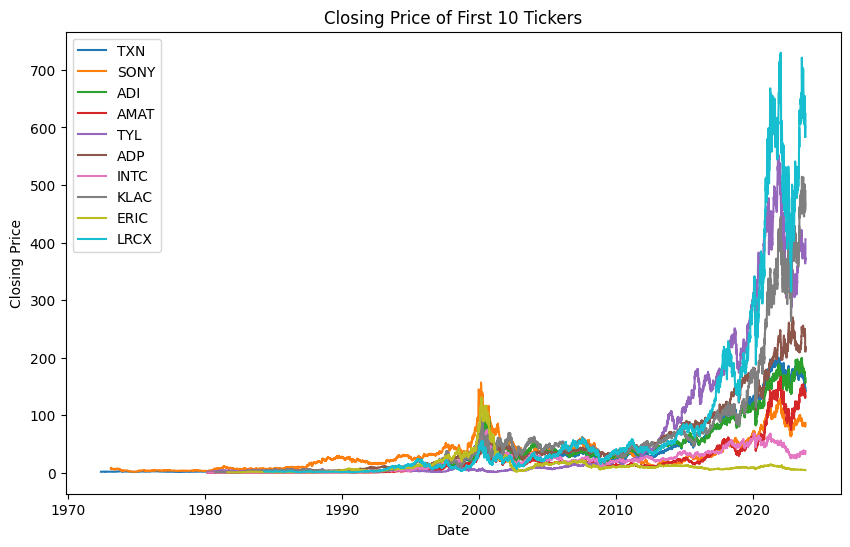

In [5]:
import matplotlib.pyplot as plt

# 2. Filter to include only the first 10 unique tickers
unique_tickers = df['Ticker'].unique()[:10]
filtered_df = df[df['Ticker'].isin(unique_tickers)]

# 3. Pivot the data
pivoted_df = filtered_df.pivot(index='Date', columns='Ticker', values='Close')

# 4. Plot the data
plt.figure(figsize=(10, 6))
for ticker in unique_tickers:
    plt.plot(pivoted_df.index, pivoted_df[ticker], label=ticker)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price of First 10 Tickers')
plt.legend()
plt.show()


## Regressors

Linear Regressor

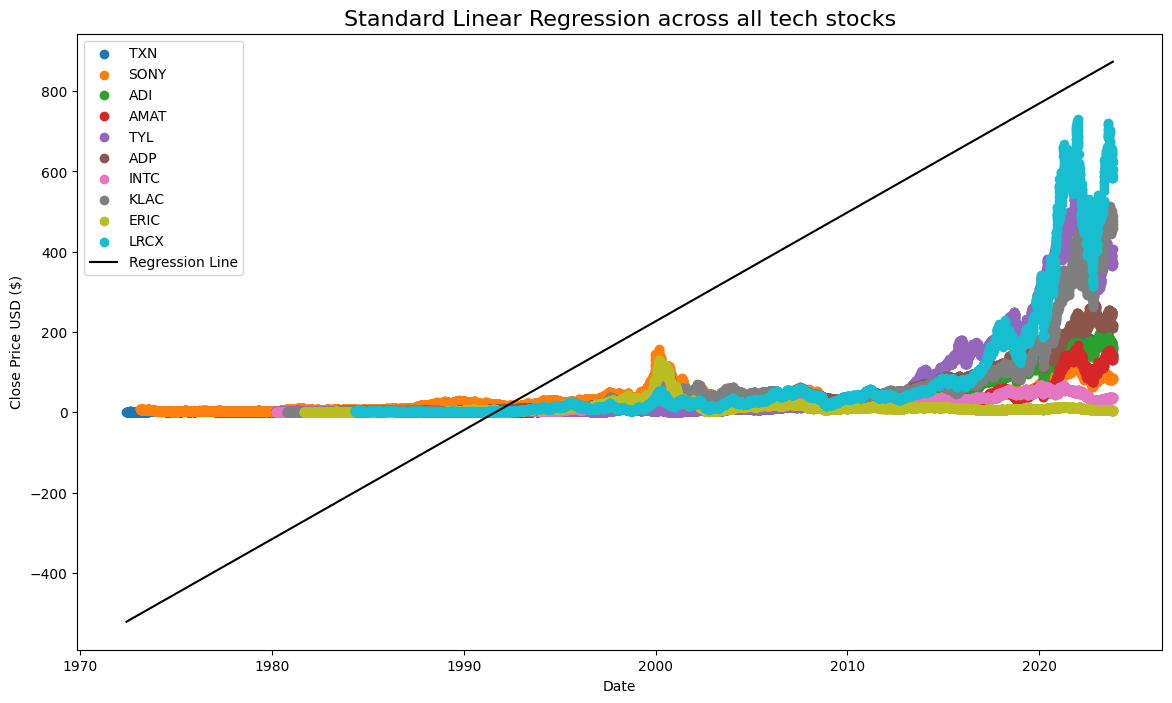

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Convert 'Date' to a numerical format for regression (days since the first date in the dataset)
df['Date'] = pd.to_datetime(df['Date'])
df['Date_ordinal'] = (df['Date'] - df['Date'].min()).dt.days

# Prepare data for regression
x = df['Date_ordinal'].values.reshape(-1, 1)
y = df['Close'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/5, random_state=42)

# Polynomial features with degree=1 is equivalent to standard linear regression
lin = PolynomialFeatures(degree=1, include_bias=False)
train_linear_features = lin.fit_transform(x_train)
test_linear_features = lin.transform(x_test)  # transform, not fit_transform

# Fit linear regression
lr_model = LinearRegression()
lr_model.fit(train_linear_features, y_train)

# Predict using all data
all_linear_features = lin.transform(x)
y_predicted = lr_model.predict(all_linear_features)

# Add the predictions back to the original dataframe
df['Standard Linear'] = y_predicted

# Get the first 10 unique tickers for plotting
tickers_to_plot = df['Ticker'].unique()[:10]

# Plotting
plt.figure(figsize=(14, 8))
for ticker in tickers_to_plot:
    df_ticker = df[df['Ticker'] == ticker]
    plt.scatter(df_ticker['Date'], df_ticker['Close'], label=ticker)

# Now plot the regression line
plt.plot(df['Date'], df['Standard Linear'], color="k", label='Regression Line')

plt.title("Standard Linear Regression across all tech stocks", size=16)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()


Polynomial Regressor

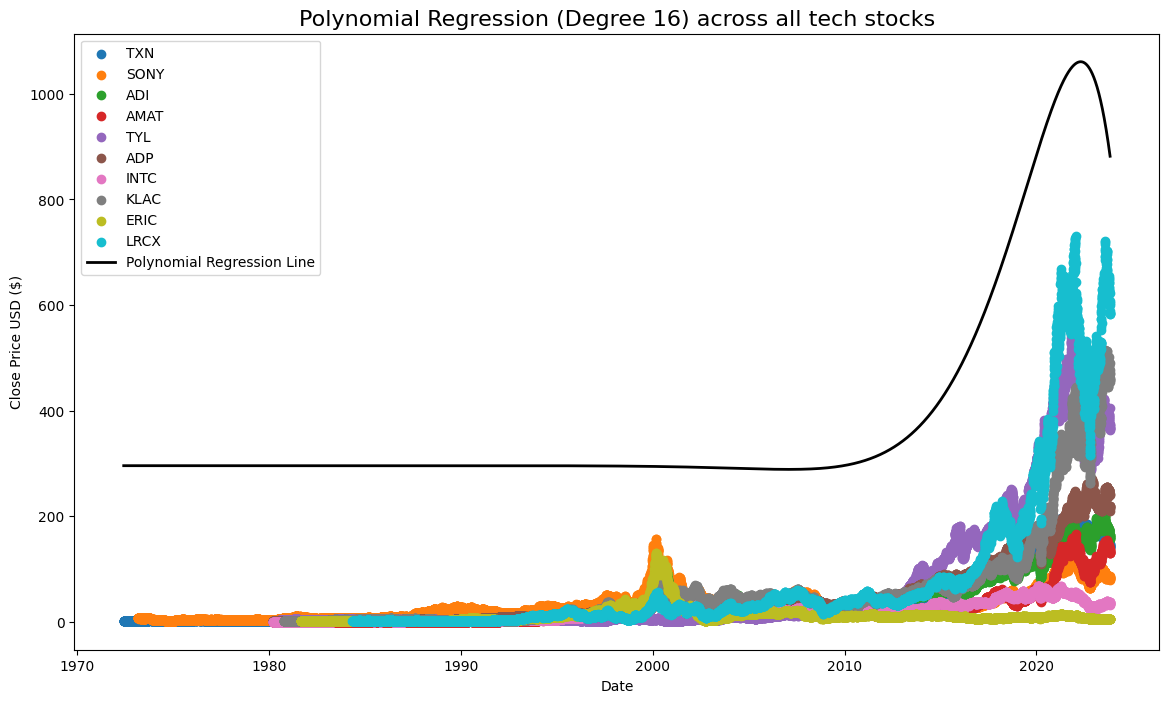

In [5]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Polynomial features with degree=16
poly = PolynomialFeatures(degree=16, include_bias=False)
train_poly_features = poly.fit_transform(x_train)
test_poly_features = poly.transform(x_test)  # transform, not fit_transform

# Fit polynomial regression using all data
poly_reg_model = LinearRegression()
poly_reg_model.fit(train_poly_features, y_train)

# Predict using the fitted model
all_poly_features = poly.transform(x)
y_predicted = poly_reg_model.predict(all_poly_features)

# Add the predictions to the dataframe
# This assumes df is sorted by date
df['Standard Polynomial'] = y_predicted

# Get the first 10 unique tickers for plotting
tickers_to_plot = df['Ticker'].unique()[:10]

# Plotting
plt.figure(figsize=(14, 8))
for ticker in tickers_to_plot:
    df_ticker = df[df['Ticker'] == ticker]
    plt.scatter(df_ticker['Date'], df_ticker['Close'], label=ticker)

# Now plot the single polynomial regression curve
# We use the 'Date' column for the x-axis and the 'Standard Polynomial' for the y-axis
plt.plot(df['Date'], df['Standard Polynomial'], color="k", label='Polynomial Regression Line', linewidth=2)

plt.title("Polynomial Regression (Degree 16) across all tech stocks", size=16)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()


Compare performance by R-score

In [6]:
x_train_float = x_train.astype(np.float64)
x_test_float = x_test.astype(np.float64)

print("Standard LinearRegression model's Training Coefficient of Determination:", lr_model.score(x_train_float.reshape(-1, 1),y_train))
print("Standard LinearRegression model's Testing Coefficient of Determination:", lr_model.score(x_test_float.reshape(-1, 1),y_test))

print("\nStandard PolynomialRegression model's Training Coefficient of Determination:", poly_reg_model.score(train_poly_features,y_train))
print("Standard PolynomialRegression model's Testing Coefficient of Determination:", poly_reg_model.score(test_poly_features,y_test))

Standard LinearRegression model's Training Coefficient of Determination: 0.008806481206862782
Standard LinearRegression model's Testing Coefficient of Determination: 0.009144291973771979

Standard PolynomialRegression model's Training Coefficient of Determination: 0.010440263962163243
Standard PolynomialRegression model's Testing Coefficient of Determination: 0.01112273116235718


As we can see, they both perform horribly, but the polynomial regressor is at least somewhat an improvement. Let's see if LASSO and Ridge might be a noticable improvement

Default LASSO Regressor

In [7]:
from sklearn.linear_model import Lasso

#Build first LASSO Regression with default hyperparameter values
lasso_default = Lasso(alpha=1, tol=0.0001, max_iter=1000)
lasso_default.fit(train_poly_features, y_train)
y_predicted = lasso_default.predict(all_poly_features)
df['Default LASSO'] = y_predicted

train_score_ls =lasso_default.score(train_poly_features, y_train)
test_score_ls =lasso_default.score(test_poly_features, y_test)
print("Default LASSO PolynomialRegression model's Training Coefficient of Determination {}".format(train_score_ls))
print("Default LASSO PolynomialRegression model's Testing Coefficient of Determination {}".format(test_score_ls))

Default LASSO PolynomialRegression model's Training Coefficient of Determination 0.010945247815906889
Default LASSO PolynomialRegression model's Testing Coefficient of Determination 0.01154086589402259


/Users/vrife/opt/anaconda3/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e+12, tolerance: 6.629e+08
  model = cd_fast.enet_coordinate_descent(


Tuned LASSO Regressor

In [8]:
#Build LASSO Regression with tuned hyperparameter values
lasso_tuned = Lasso(alpha=10, tol=0.0000001, max_iter=10000)
lasso_tuned.fit(train_poly_features, y_train)
y_predicted = lasso_tuned.predict(all_poly_features)
df['Tuned LASSO'] = y_predicted

train_score_ls =lasso_tuned.score(train_poly_features, y_train)
test_score_ls =lasso_tuned.score(test_poly_features, y_test)
print("Tuned LASSO PolynomialRegression model's Training Coefficient of Determination {}".format(train_score_ls))
print("Tuned LASSO PolynomialRegression model's Testing Coefficient of Determination {}".format(test_score_ls))

Tuned LASSO PolynomialRegression model's Training Coefficient of Determination 0.011957545447576101
Tuned LASSO PolynomialRegression model's Testing Coefficient of Determination 0.012541237560523943


/Users/vrife/opt/anaconda3/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+12, tolerance: 6.629e+05
  model = cd_fast.enet_coordinate_descent(


As we see, the LASSO regressor does help, and so does tuning it. But the R-scores are still very low.

Now let's plot both and compare

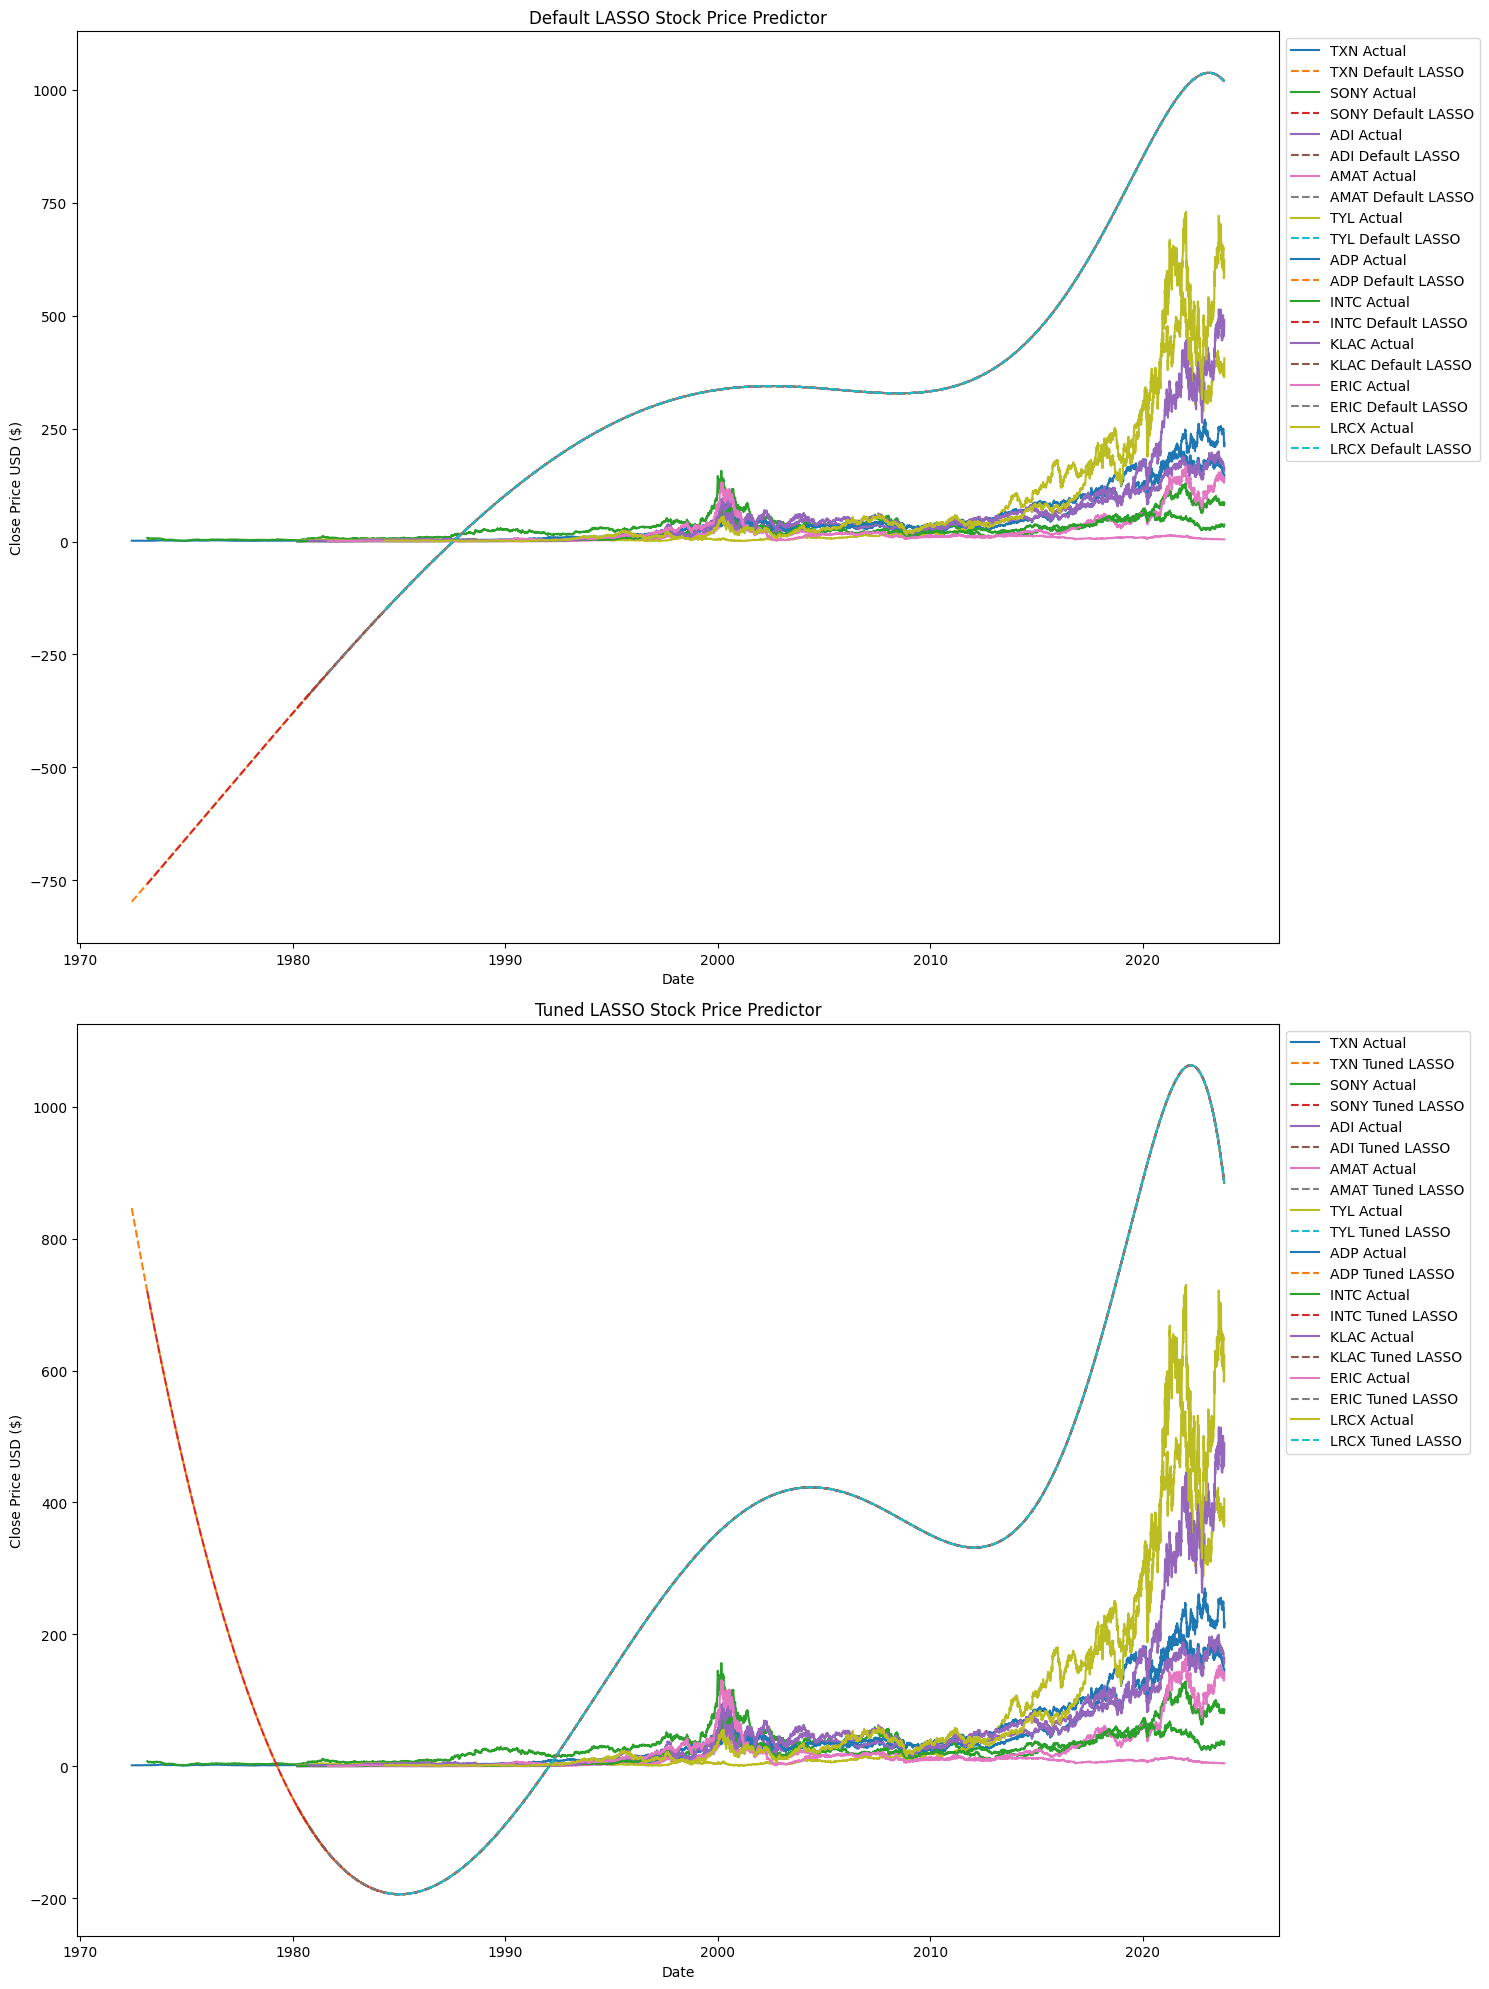

In [11]:
import matplotlib.pyplot as plt

# Assume df, lasso_default, lasso_tuned, and poly are already defined
# Assume that df has 'Date' as a datetime column and 'Date_ordinal' as the ordinal equivalent for modeling

# Get the top 10 unique tickers
tickers_to_plot = df['Ticker'].unique()[:10]

# Create two subplots, one for Default LASSO and one for Tuned LASSO
fig, axs = plt.subplots(2, 1, figsize=(15, 20))

# Loop over each ticker and plot on the same axes
for ticker in tickers_to_plot:
    # Filter data for the current ticker
    df_ticker = df[df['Ticker'] == ticker]
    x_ticker = df_ticker['Date_ordinal'].values.reshape(-1, 1)
    y_ticker = df_ticker['Close'].values

    # Calculate LASSO predictions for the ticker
    ticker_poly_features = poly.transform(x_ticker)
    y_pred_default = lasso_default.predict(ticker_poly_features)
    y_pred_tuned = lasso_tuned.predict(ticker_poly_features)

    # Plot the actual stock prices and predictions for Default LASSO
    axs[0].plot(df_ticker['Date'], y_ticker, label=f'{ticker} Actual')
    axs[0].plot(df_ticker['Date'], y_pred_default, linestyle='--', label=f'{ticker} Default LASSO')

    # Plot the actual stock prices and predictions for Tuned LASSO
    axs[1].plot(df_ticker['Date'], y_ticker, label=f'{ticker} Actual')
    axs[1].plot(df_ticker['Date'], y_pred_tuned, linestyle='--', label=f'{ticker} Tuned LASSO')

# Set titles, labels, and legends
axs[0].set_title('Default LASSO Stock Price Predictor')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Close Price USD ($)')
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

axs[1].set_title('Tuned LASSO Stock Price Predictor')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Close Price USD ($)')
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the layout
plt.tight_layout()
plt.show()


The plots look at least a little more representative than before. Let's see how it does with Ridge Regressors

Default Ridge Regressor

In [12]:
from sklearn.linear_model import Ridge

#Build first Ridge Regression with default hyperparameter values
ridge_default = Ridge(alpha = 1, tol=0.001)

poly = PolynomialFeatures(degree=5, include_bias=False)
all_poly_features = poly.fit_transform(x.reshape(-1, 1))
train_poly_features = poly.fit_transform(x_train.reshape(-1, 1))
test_poly_features = poly.fit_transform(x_test.reshape(-1, 1))

ridge_default.fit(train_poly_features, y_train)
y_predicted = ridge_default.predict(all_poly_features)
df['Default Ridge'] = y_predicted

train_score_ridge = ridge_default.score(train_poly_features, y_train)
test_score_ridge = ridge_default.score(test_poly_features, y_test)
print("Default Ridge PolynomialRegression model's Training Coefficient of Determination {}".format(train_score_ridge))
print("Default Ridge PolynomialRegression model's Testing Coefficient of Determination {}".format(test_score_ridge))

Default Ridge PolynomialRegression model's Training Coefficient of Determination 0.010806989422745272
Default Ridge PolynomialRegression model's Testing Coefficient of Determination 0.011409043360601112


/Users/vrife/opt/anaconda3/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.85631e-39): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Tuned Ridge Regressor

In [16]:
#Build Ridge Regression with tuned hyperparameter values
ridge_tuned = Ridge(alpha=10, tol=0.0000001, max_iter=1000000)
ridge_tuned.fit(train_poly_features,y_train)
y_predicted = ridge_tuned.predict(all_poly_features)
df['Tuned Ridge'] = y_predicted

train_score_ridge = ridge_tuned.score(train_poly_features, y_train)
test_score_ridge = ridge_tuned.score(test_poly_features, y_test)
print("Tuned Ridge PolynomialRegression model's Training Coefficient of Determination {}".format(train_score_ridge))
print("Tuned Ridge PolynomialRegression model's Testing Coefficient of Determination {}".format(test_score_ridge))

Tuned Ridge PolynomialRegression model's Training Coefficient of Determination 0.010806989422745827
Tuned Ridge PolynomialRegression model's Testing Coefficient of Determination 0.011409043360644633


/Users/vrife/opt/anaconda3/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.85631e-39): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


As we see, it appears the Ridge regressor actually performs worse than LASSO.

Now lets plot and compare

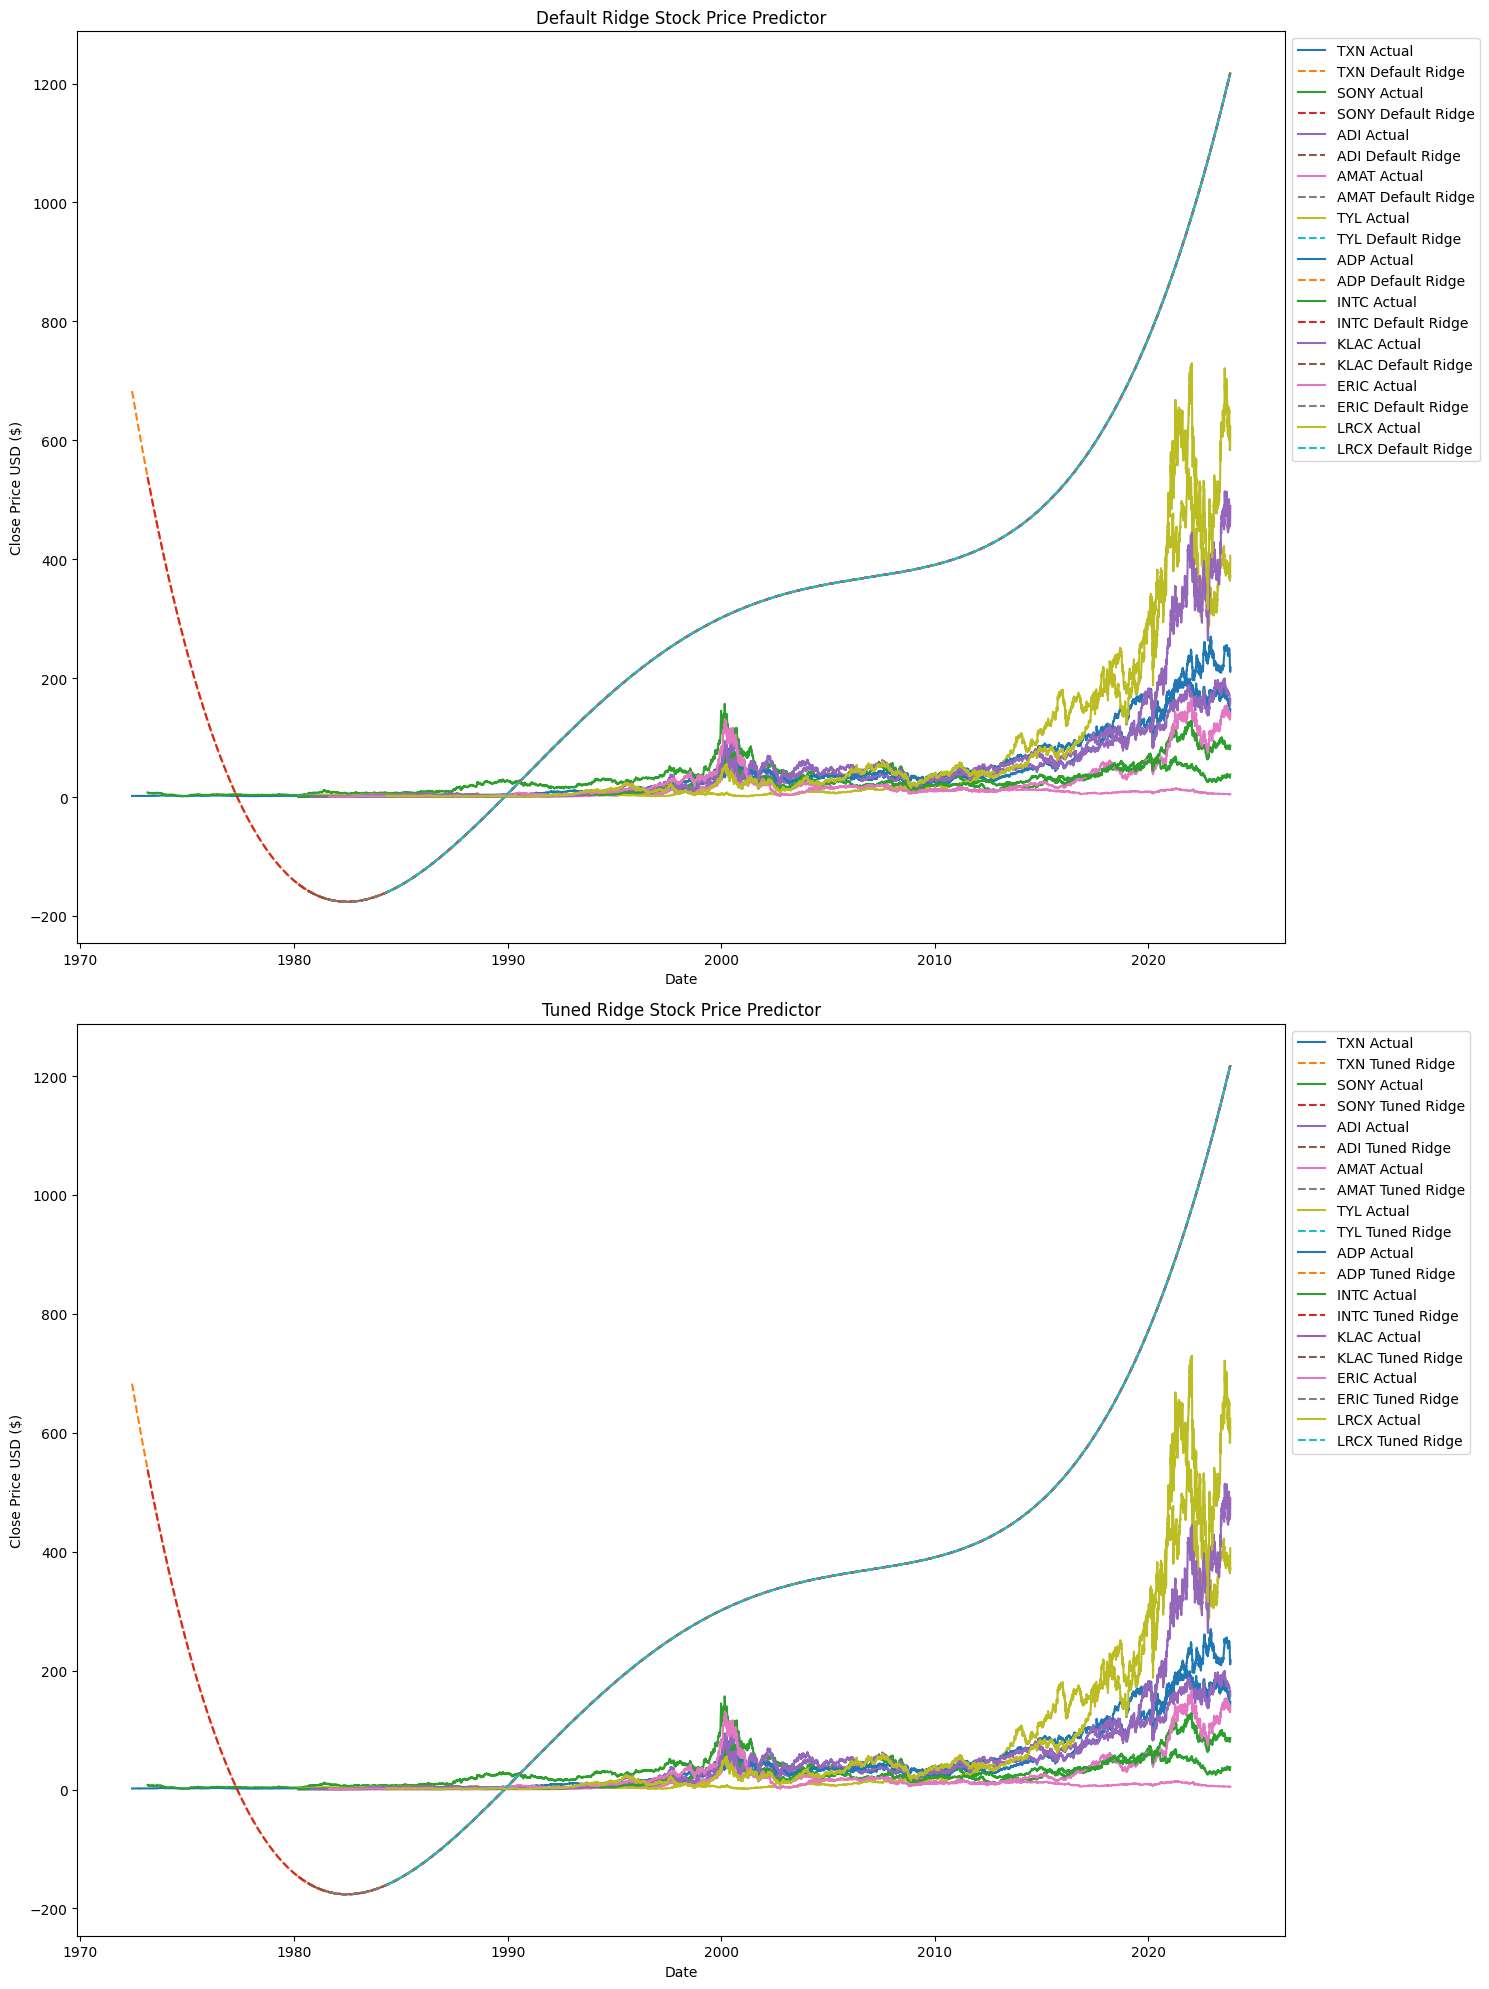

In [17]:
import matplotlib.pyplot as plt

# Get the top 10 unique tickers
tickers_to_plot = df['Ticker'].unique()[:10]

# Create two subplots, one for Default LASSO and one for Tuned LASSO
fig, axs = plt.subplots(2, 1, figsize=(15, 20))

# Loop over each ticker and plot on the same axes
for ticker in tickers_to_plot:
    # Filter data for the current ticker
    df_ticker = df[df['Ticker'] == ticker]
    x_ticker = df_ticker['Date_ordinal'].values.reshape(-1, 1)
    y_ticker = df_ticker['Close'].values

    # Calculate LASSO predictions for the ticker
    ticker_poly_features = poly.transform(x_ticker)
    y_pred_default = ridge_default.predict(ticker_poly_features)
    y_pred_tuned = ridge_tuned.predict(ticker_poly_features)

    # Plot the actual stock prices and predictions for Default LASSO
    axs[0].plot(df_ticker['Date'], y_ticker, label=f'{ticker} Actual')
    axs[0].plot(df_ticker['Date'], y_pred_default, linestyle='--', label=f'{ticker} Default Ridge')

    # Plot the actual stock prices and predictions for Tuned LASSO
    axs[1].plot(df_ticker['Date'], y_ticker, label=f'{ticker} Actual')
    axs[1].plot(df_ticker['Date'], y_pred_tuned, linestyle='--', label=f'{ticker} Tuned Ridge')

# Set titles, labels, and legends
axs[0].set_title('Default Ridge Stock Price Predictor')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Close Price USD ($)')
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

axs[1].set_title('Tuned Ridge Stock Price Predictor')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Close Price USD ($)')
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the layout
plt.tight_layout()
plt.show()


Very similar to the LASSO Regressor. That is, still quite bad. As we've now made certain, regressors are horrible for this task. We continue to training our neural networks

## CNN

In [17]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess data and create time series for all stocks
def create_time_series(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

scalers = {}
for ticker in df['Ticker'].unique():
    scaler = MinMaxScaler(feature_range=(0, 1))
    ticker_data = df[df['Ticker'] == ticker]['Close'].values.reshape(-1, 1)
    scaler.fit(ticker_data)
    scalers[ticker] = scaler

# Assuming 'df' is your DataFrame and it contains 'Close' prices for different stocks identified by 'Ticker'
all_series = []
all_targets = []

n_steps = 60  # Set your desired number of steps

for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker]['Close'].values.reshape(-1, 1)
    if len(ticker_data) > n_steps:  # Ensure there's enough data
        scaled_data = scalers[ticker].transform(ticker_data)
        X, y = create_time_series(scaled_data, n_steps)
        if X.shape[0] > 0:  # Check if the series is not empty
            all_series.append(X)
            all_targets.append(y)

# Now concatenate
X = np.concatenate(all_series, axis=0)
y = np.concatenate(all_targets, axis=0)

# Reshape for CNN
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Create CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model with the early stopping callback
model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/20
25327/25327 [==============================] - 401s 16ms/step - loss: 7.7597e-04 - val_loss: 0.0012
Epoch 2/20
25327/25327 [==============================] - 400s 16ms/step - loss: 6.2898e-04 - val_loss: 0.0014
Epoch 3/20
25327/25327 [==============================] - 396s 16ms/step - loss: 5.9358e-04 - val_loss: 0.0013
Epoch 4/20
25327/25327 [==============================] - 397s 16ms/step - loss: 5.7326e-04 - val_loss: 0.0012
Epoch 5/20
25327/25327 [==============================] - 398s 16ms/step - loss: 5.5735e-04 - val_loss: 0.0011
Epoch 6/20
25327/25327 [==============================] - 403s 16ms/step - loss: 5.4956e-04 - val_loss: 0.0011
Epoch 7/20
25327/25327 [==============================] - 408s 16ms/step - loss: 5.4313e-04 - val_loss: 0.0019
Epoch 8/20
25327/25327 [==============================] - 418s 16ms/step - loss: 5.3983e-04 - val_loss: 0.0016
Epoch 9/20
25327/25327 [==============================] - 459s 18ms/step - loss: 5.3337e-04 - val_loss: 0.0021


In [19]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


6332/6332 [==============================] - 42s 7ms/step
Mean Squared Error: 0.0011127290781587362
Mean Absolute Error: 0.028672249987721443


404/404 [==============================] - 2s 4ms/step


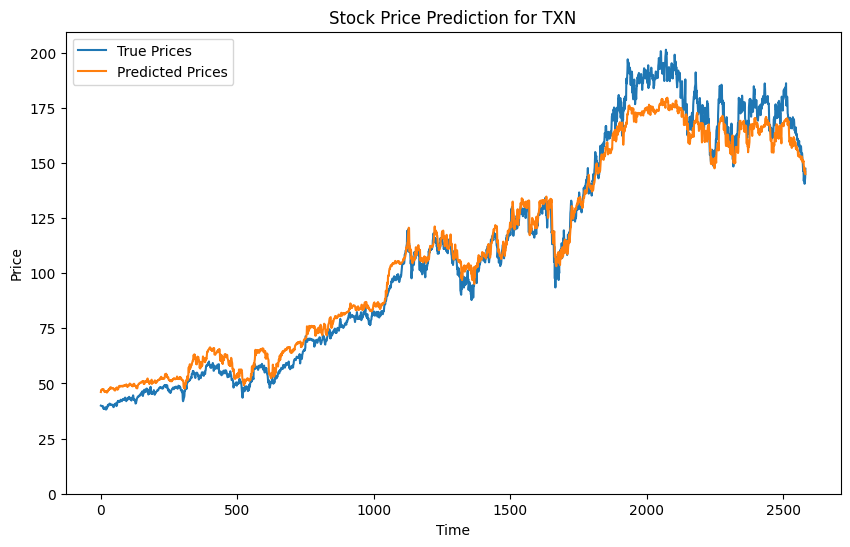

398/398 [==============================] - 2s 6ms/step


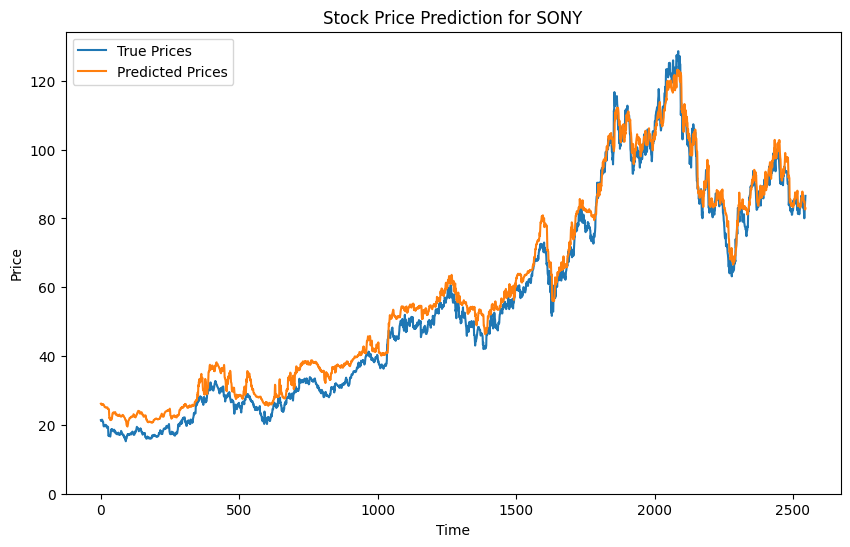

342/342 [==============================] - 2s 5ms/step


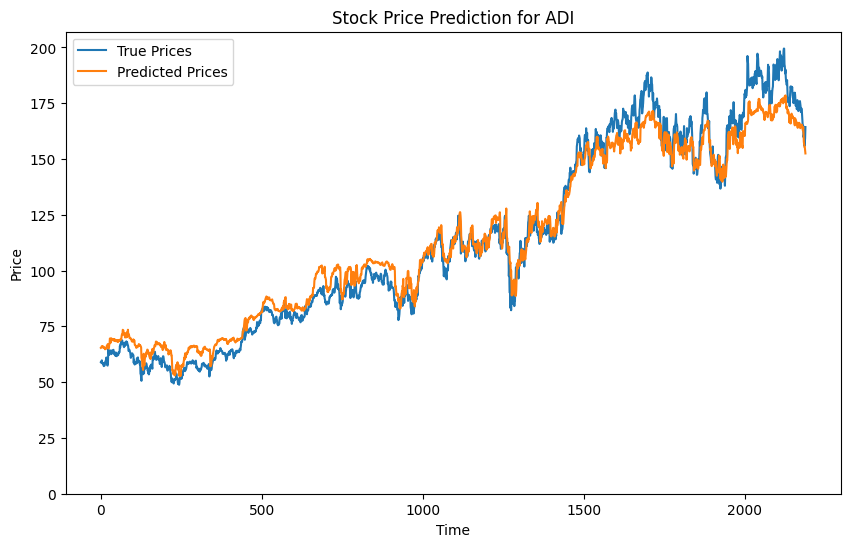

342/342 [==============================] - 1s 4ms/step


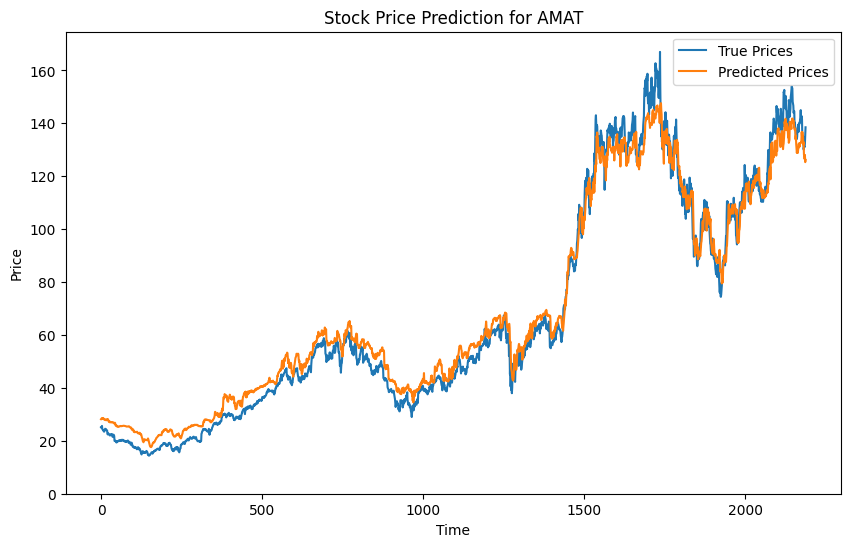

342/342 [==============================] - 2s 5ms/step


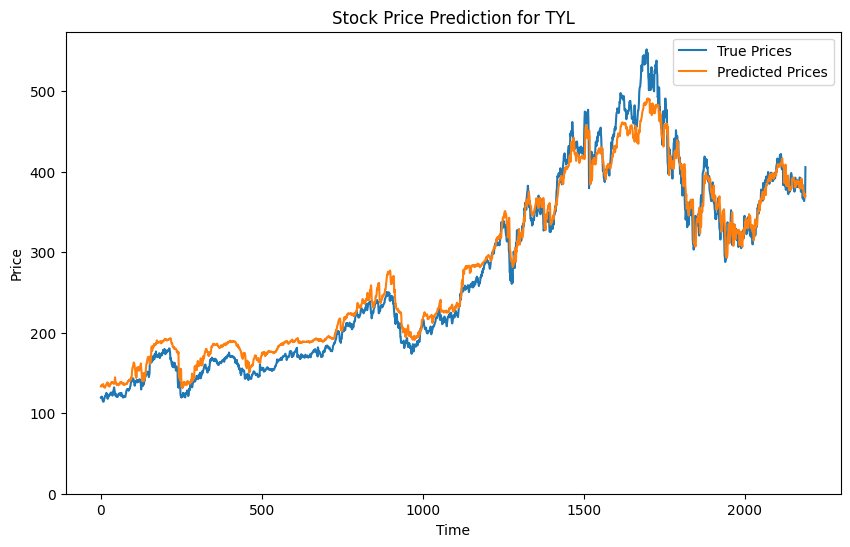

342/342 [==============================] - 1s 4ms/step


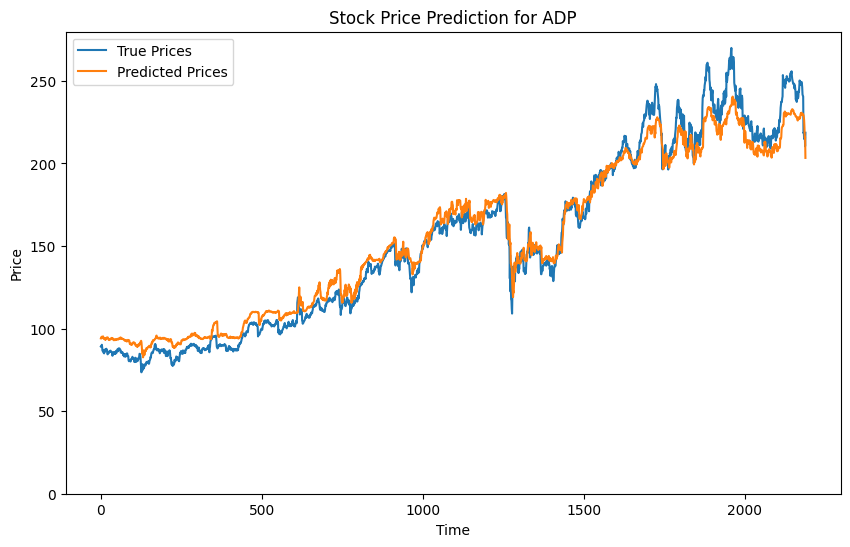

342/342 [==============================] - 2s 5ms/step


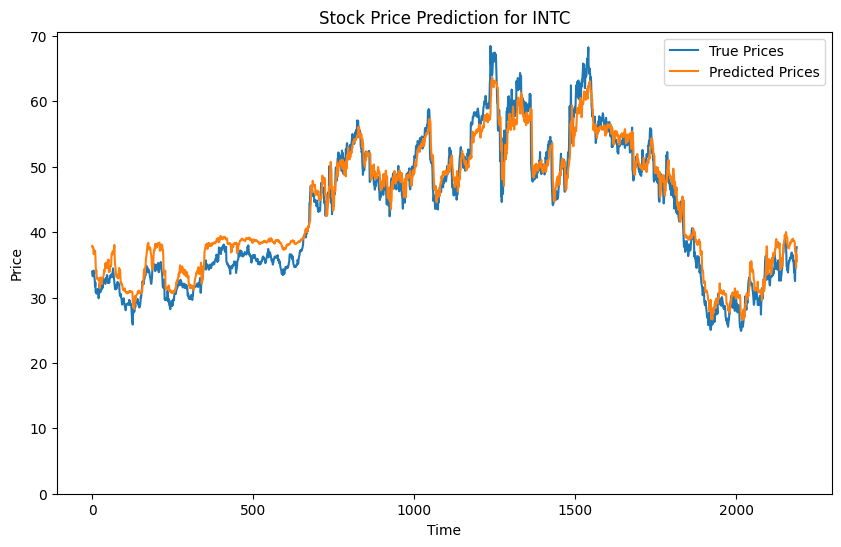

338/338 [==============================] - 1s 4ms/step


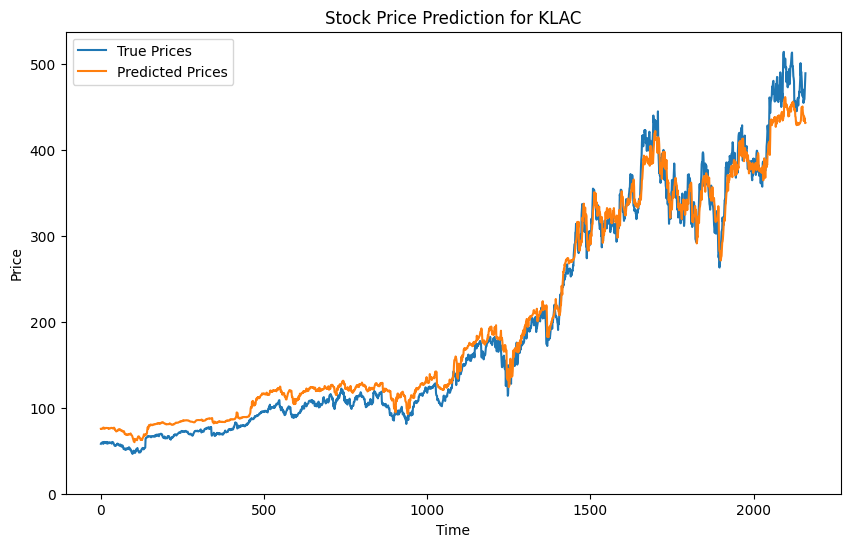

331/331 [==============================] - 2s 5ms/step


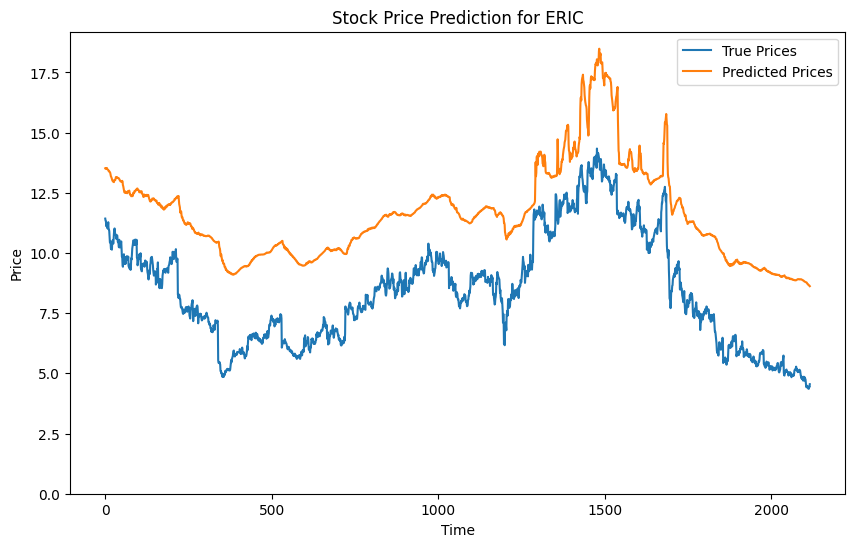

310/310 [==============================] - 1s 4ms/step


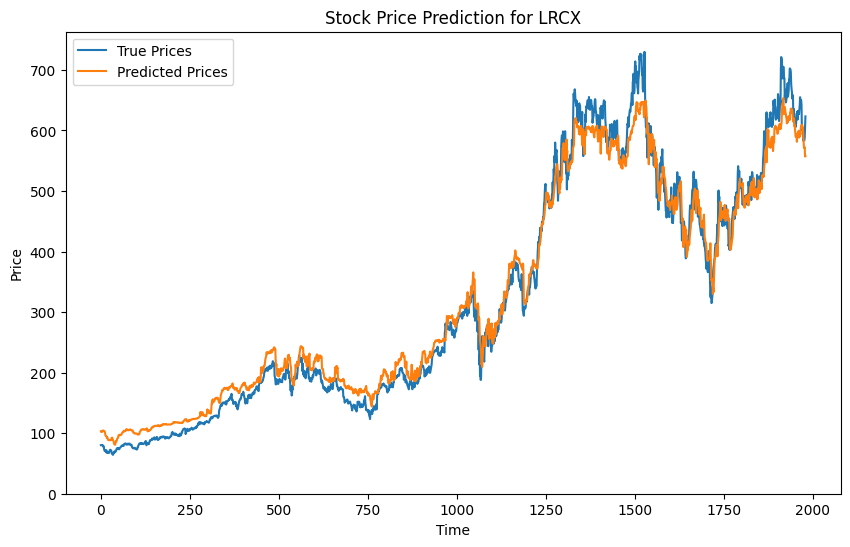

In [20]:
import matplotlib.pyplot as plt

# Define the function to get the number of test samples for each ticker
def get_test_samples_per_ticker(ticker, X, y):
    _, X_test_ticker, _, y_test_ticker = train_test_split(X, y, test_size=0.2, random_state=42)
    return len(y_test_ticker)

# Plotting function
def plot_predictions(ticker, true_values, predicted_values):
    plt.figure(figsize=(10, 6))
    plt.plot(true_values, label='True Prices')
    plt.plot(predicted_values, label='Predicted Prices')
    plt.title(f"Stock Price Prediction for {ticker}")
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.ylim(bottom=0)  # Set the lower y-limit to 0
    plt.legend()
    plt.show()

# Generate predictions and plot for top tickers
top_tickers = df['Ticker'].value_counts().head(10).index

# Predict and plot for each of the top tickers
for ticker in top_tickers:
    ticker_data = df[df['Ticker'] == ticker]['Close'].values.reshape(-1, 1)
    scaled_data = scalers[ticker].transform(ticker_data)
    X, y = create_time_series(scaled_data, n_steps)

    if X.shape[0] > 0:
        X = X.reshape((X.shape[0], X.shape[1], 1))
        predicted_scaled = model.predict(X)

        # Calculate the number of test samples for the current ticker
        test_samples = get_test_samples_per_ticker(ticker, X, y)

        true_values = scalers[ticker].inverse_transform(y.reshape(-1, 1)).flatten()
        predicted_values = scalers[ticker].inverse_transform(predicted_scaled).flatten()

        # Plot only for the validation period
        val_period = range(len(true_values) - test_samples, len(true_values))
        plot_predictions(ticker, true_values[val_period], predicted_values[val_period])


1/1 [==============================] - 0s 33ms/step


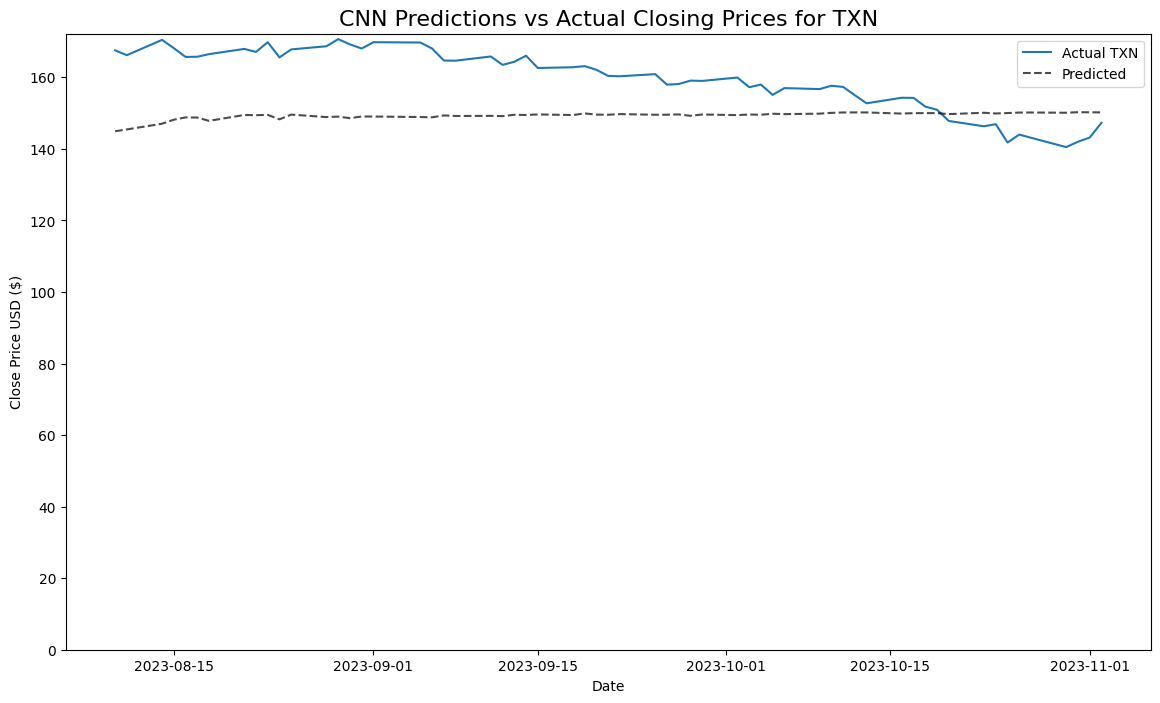

1/1 [==============================] - 0s 53ms/step


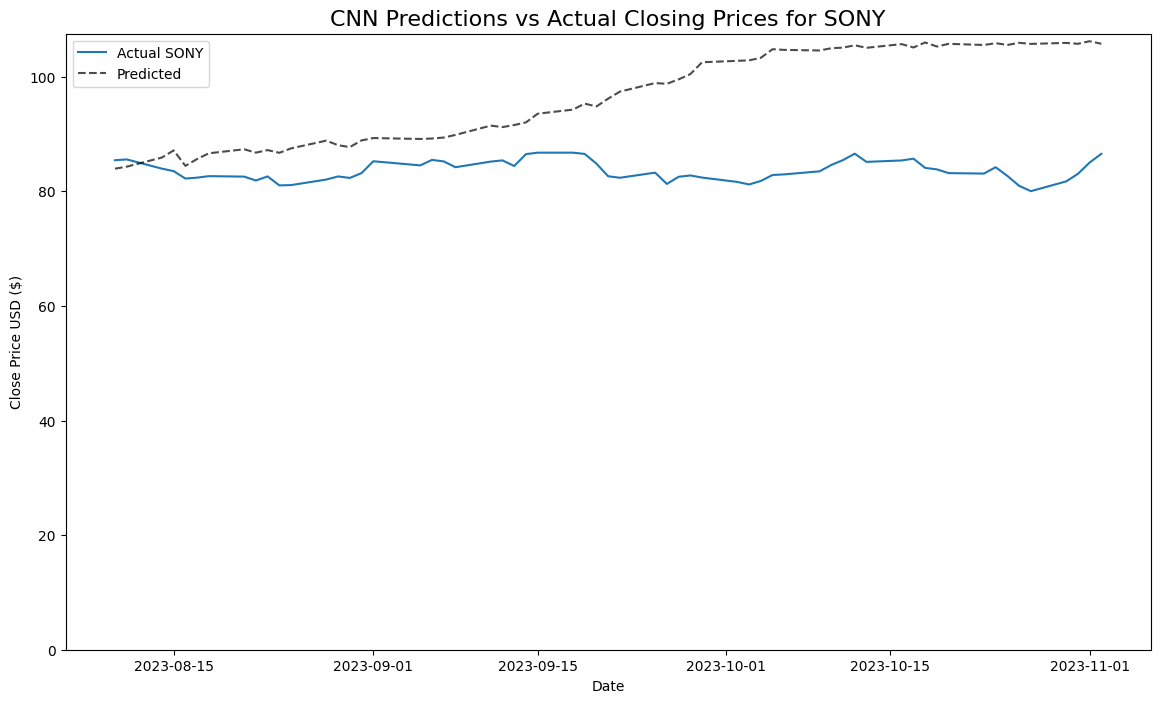

1/1 [==============================] - 0s 31ms/step


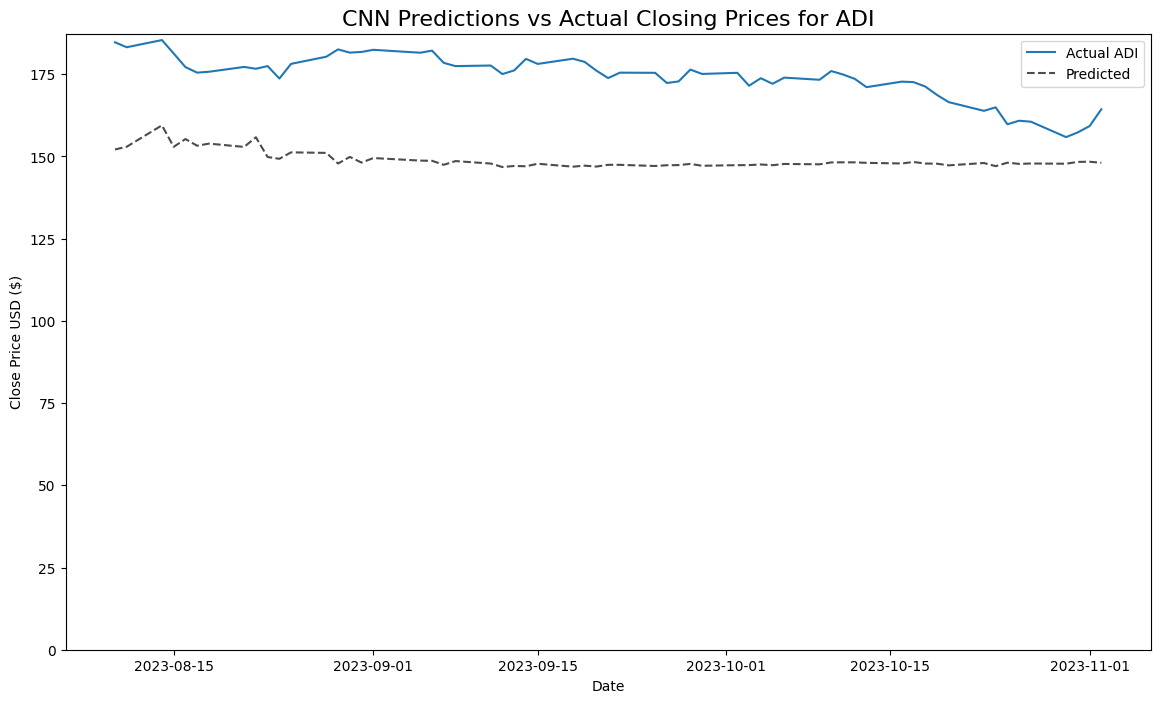

1/1 [==============================] - 0s 31ms/step


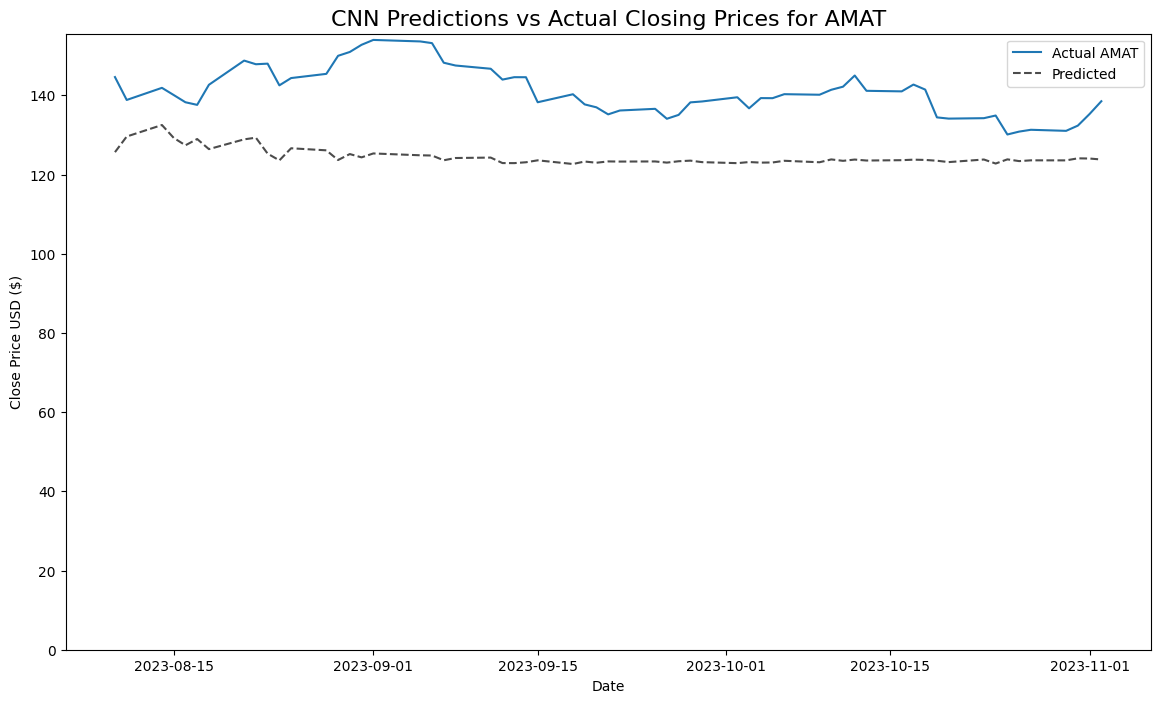

1/1 [==============================] - 0s 45ms/step


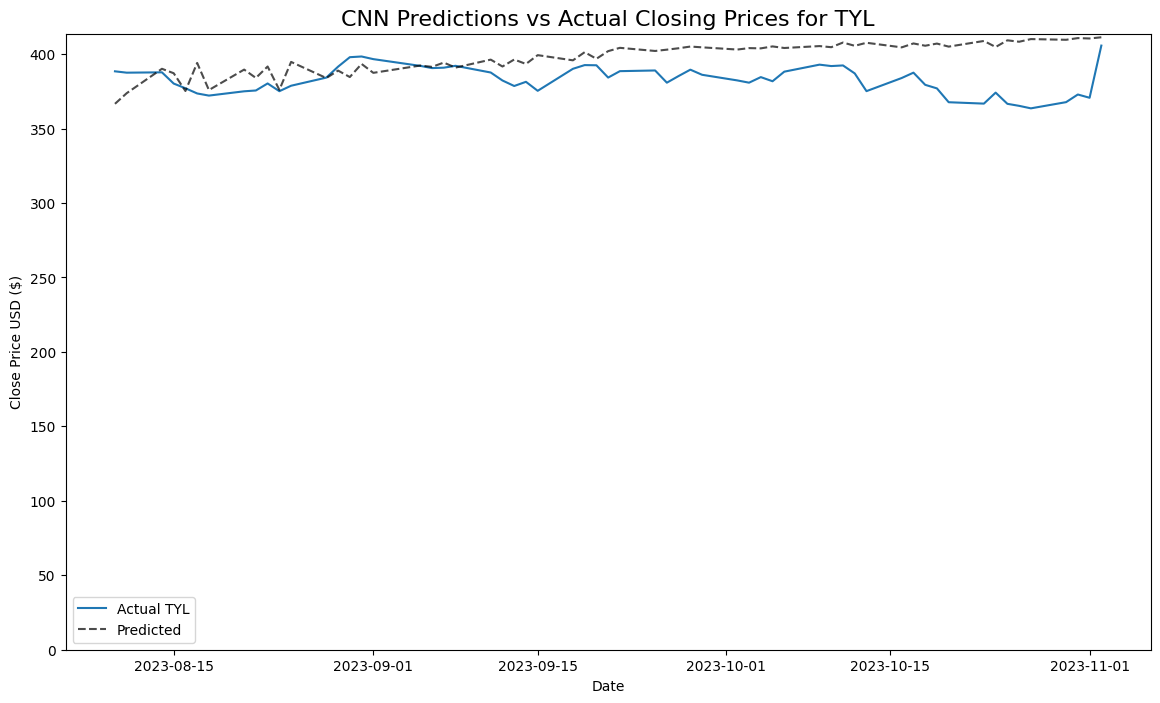

1/1 [==============================] - 0s 37ms/step


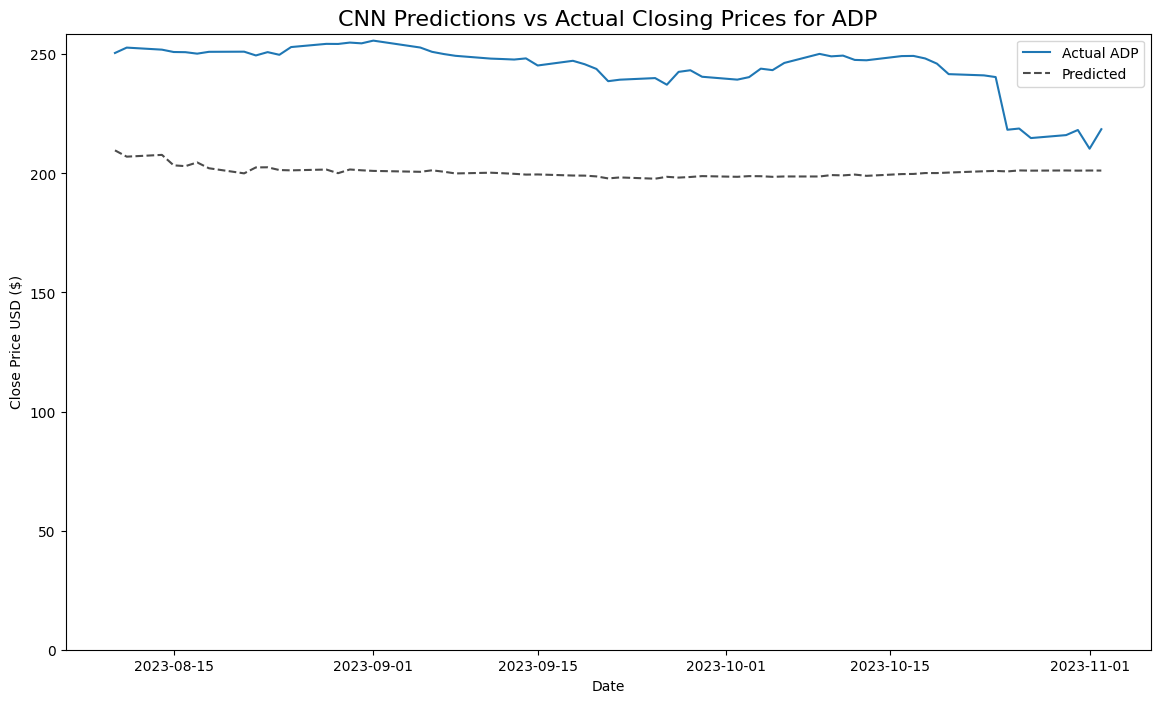

1/1 [==============================] - 0s 37ms/step


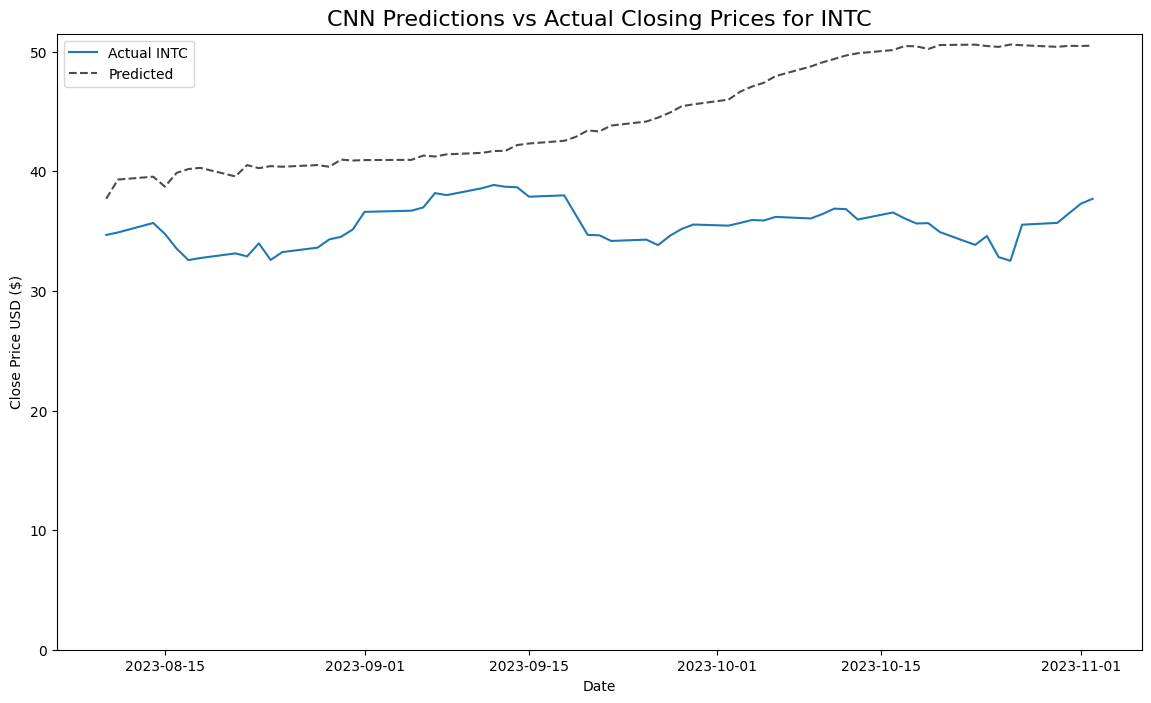

1/1 [==============================] - 0s 65ms/step


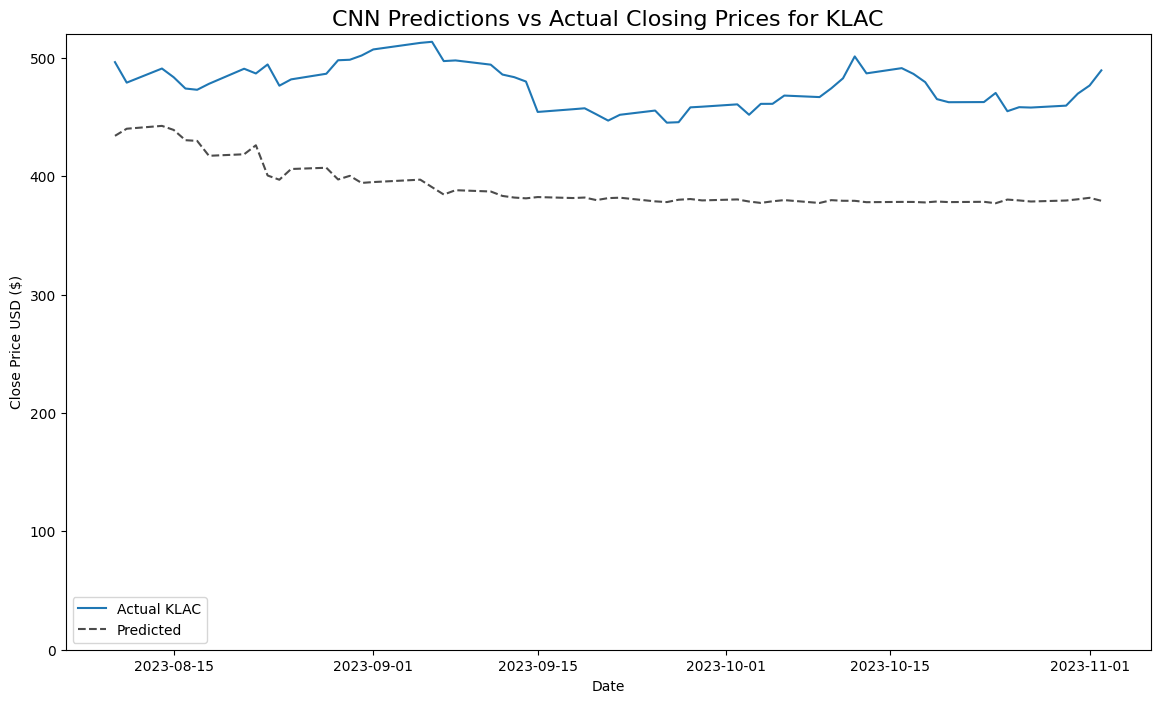

1/1 [==============================] - 0s 30ms/step


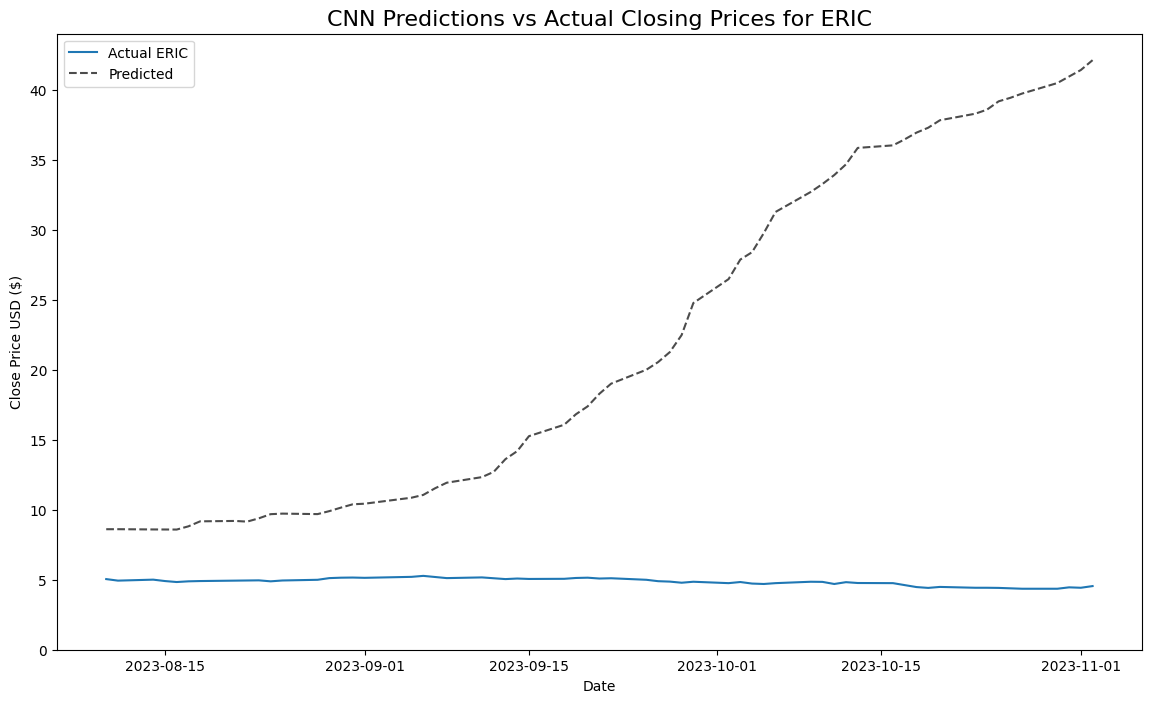

1/1 [==============================] - 0s 41ms/step


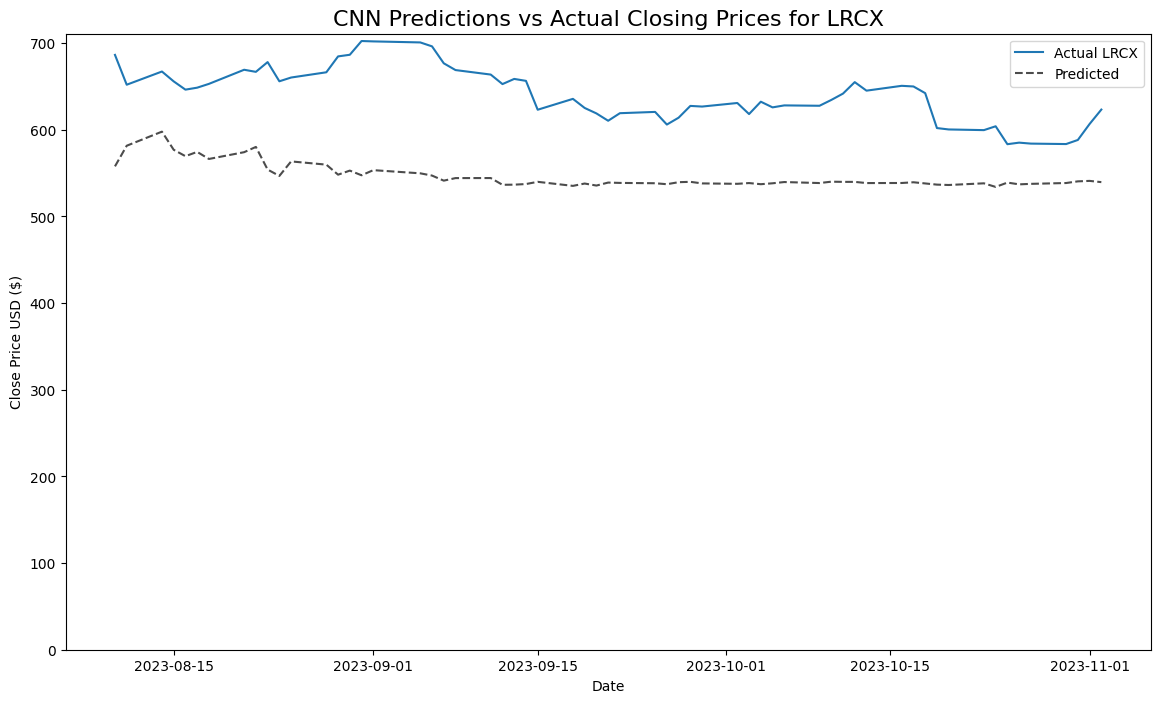

In [21]:
# Predict sequence function using the CNN model
def predict_sequence(input_sequence, model, n_steps, scaler):
    result = []
    input_data = input_sequence.copy()
    for _ in range(n_steps):
        scaled_prediction = model.predict(input_data[-X_train.shape[1]:].reshape(1, -1, 1))[0, 0]
        prediction = scaler.inverse_transform([[scaled_prediction]])[0][0]
        result.append(prediction)
        input_data = np.append(input_data[1:], scaled_prediction)  # Append scaled value
    return result


# Generate predictions and plot for top tickers
top_tickers = df['Ticker'].value_counts().head(10).index

for ticker in top_tickers:
    ticker_data = df[df['Ticker'] == ticker]
    last_prices = ticker_data['Close'].values[-X_train.shape[1]:]
    scaler = scalers[ticker]
    last_prices_scaled = scaler.transform(last_prices.reshape(-1, 1)).flatten()
    predicted_prices_scaled = predict_sequence(last_prices_scaled, model, X_train.shape[1], scaler)
    actual_dates = ticker_data['Date'].values[-X_train.shape[1]:]
    predicted_prices = np.array(predicted_prices_scaled)
    plt.figure(figsize=(14, 8))
    plt.title(f"CNN Predictions vs Actual Closing Prices for {ticker}", size=16)
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(actual_dates, last_prices, label=f'Actual {ticker}')
    plt.plot(actual_dates, predicted_prices, 'k--', label='Predicted', alpha=0.7)
    plt.ylim(bottom=0)  # Set the lower y-limit to 0
    plt.legend()
    plt.show()

## Saving/Loading CNN

In [28]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 58, 64)            256       
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 29, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 29, 64)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 27, 128)           24704     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 13, 128)           0         
 ng1D)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 13, 128)          

In [29]:
model.save(save_format='h5', filepath="cnn.h5")
model.save('cnn.keras')

In [32]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import tensorflow as tf

# Declare CNN model
# model = Sequential([
#     Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
#     MaxPooling1D(pool_size=2),
#     Dropout(0.2),
#     Conv1D(filters=128, kernel_size=3, activation='relu'),
#     MaxPooling1D(pool_size=2),
#     Dropout(0.2),
#     Flatten(),
#     Dense(100, activation='relu'),
#     Dense(1)
# ])

model = tf.keras.models.load_model('cnn.keras')
# model.summary()

## LSTM

In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to preprocess data and create time series for all stocks
def create_time_series(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

scalers = {}
for ticker in df['Ticker'].unique():
    scaler = MinMaxScaler(feature_range=(0, 1))
    ticker_data = df[df['Ticker'] == ticker]['Close'].values.reshape(-1, 1)
    scaler.fit(ticker_data)
    scalers[ticker] = scaler

# ... (assuming you have already preprocessed and created the all_data array)
# Assuming 'df' is your DataFrame and it contains 'Close' prices for different stocks identified by 'Ticker'
all_series = []
all_targets = []

n_steps = 60  # Set your desired number of steps

for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker]['Close'].values.reshape(-1, 1)
    if len(ticker_data) > n_steps:  # Ensure there's enough data
        scaled_data = scalers[ticker].transform(ticker_data)
        X, y = create_time_series(scaled_data, n_steps)
        if X.shape[0] > 0:  # Check if the series is not empty
            all_series.append(X)
            all_targets.append(y)

# Now concatenate
X = np.concatenate(all_series, axis=0)
y = np.concatenate(all_targets, axis=0)

# Reshape for CNN
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Improved LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1), stateful=False),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(
    X_train, y_train,
    epochs=20,  # Increased epochs to 25
    batch_size=32,  # Adjusted batch size to 64
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/20
25327/25327 [==============================] - 3897s 154ms/step - loss: 3.4147e-04 - val_loss: 3.9999e-04
Epoch 2/20
25327/25327 [==============================] - 3205s 127ms/step - loss: 2.0134e-04 - val_loss: 9.1082e-04
Epoch 3/20
25327/25327 [==============================] - 2906s 115ms/step - loss: 1.7182e-04 - val_loss: 0.0016
Epoch 4/20
25327/25327 [==============================] - 2800s 111ms/step - loss: 1.6174e-04 - val_loss: 0.0017


In [24]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

6332/6332 [==============================] - 220s 34ms/step
Mean Squared Error: 0.00039998895954340696
Mean Absolute Error: 0.016018569469451904


404/404 [==============================] - 14s 34ms/step


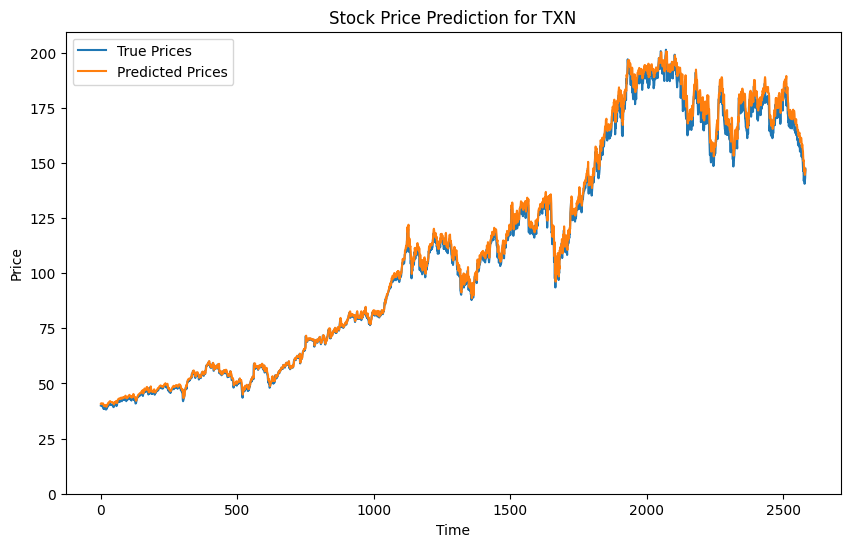

398/398 [==============================] - 14s 34ms/step


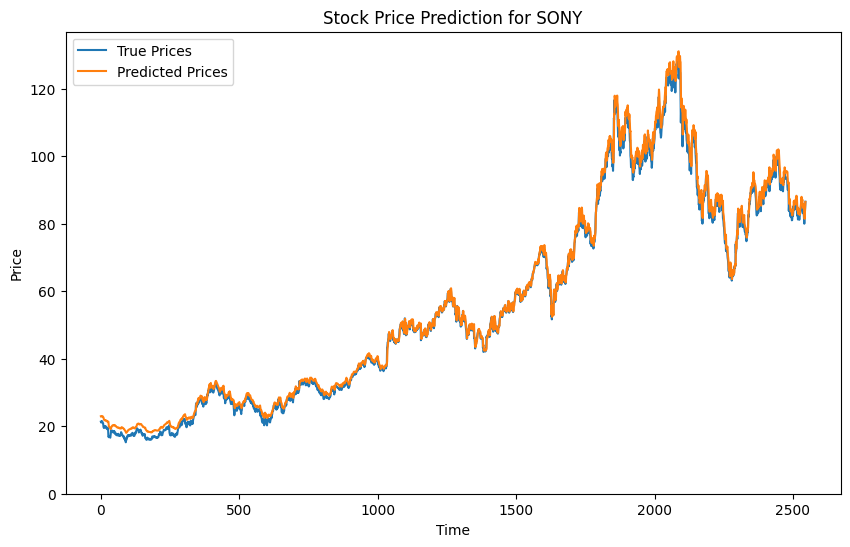

342/342 [==============================] - 12s 34ms/step


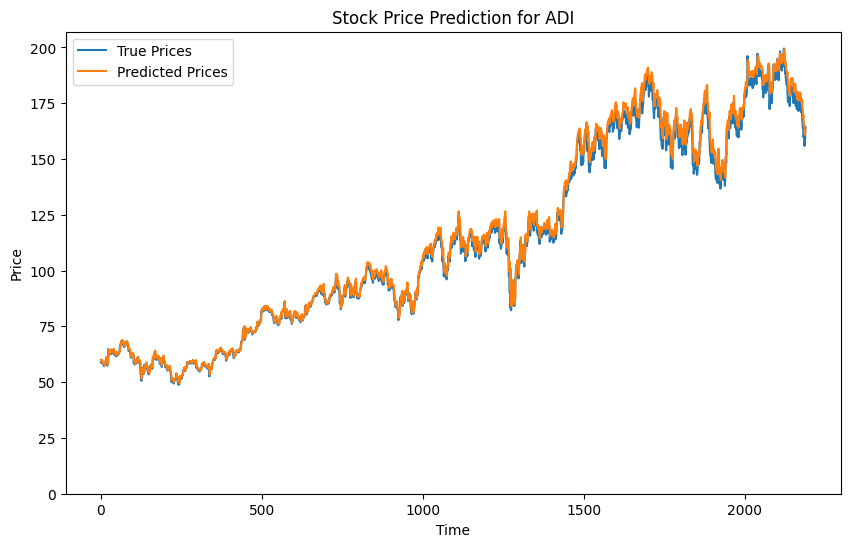

342/342 [==============================] - 11s 34ms/step


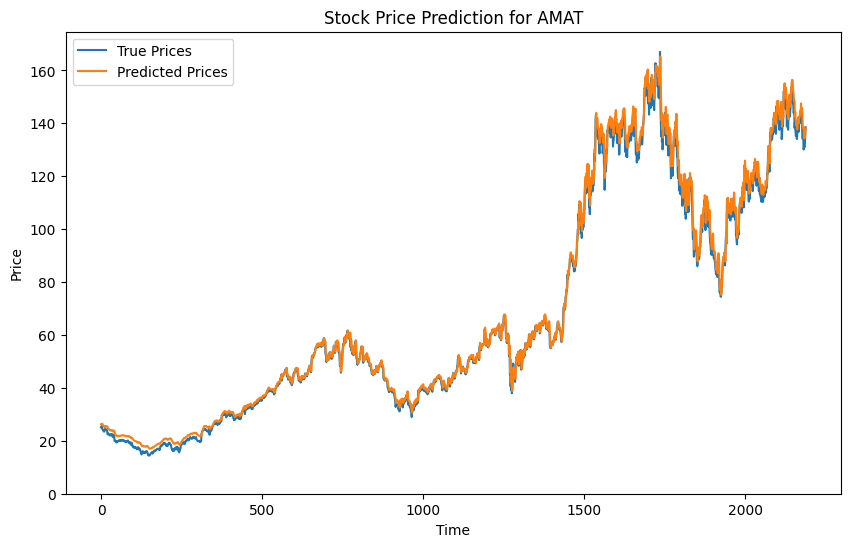

342/342 [==============================] - 12s 34ms/step


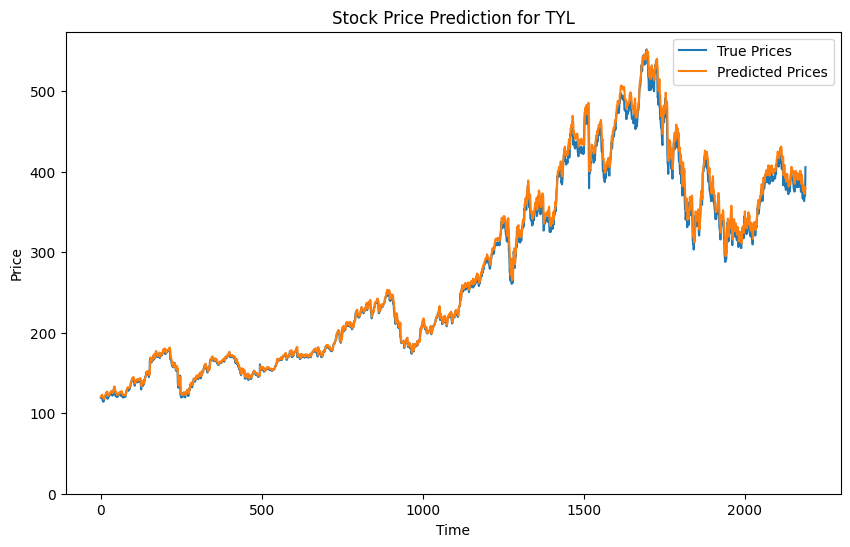

342/342 [==============================] - 12s 34ms/step


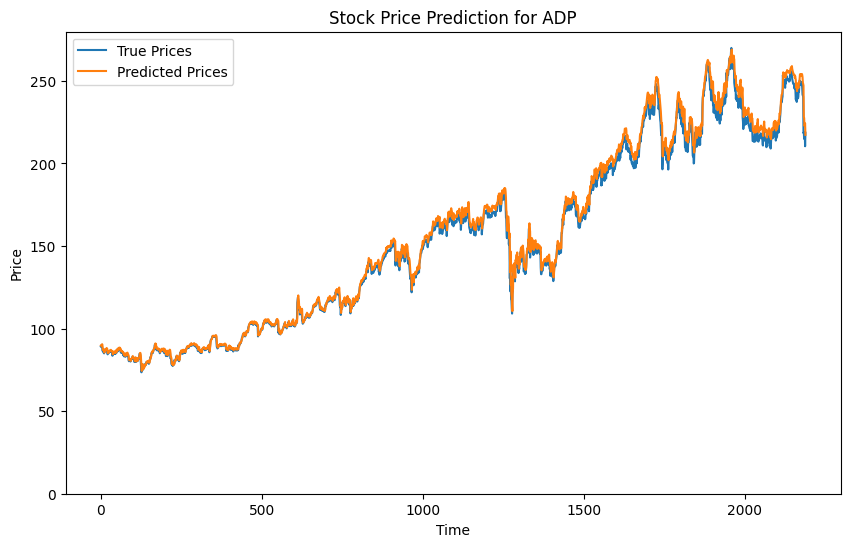

342/342 [==============================] - 12s 35ms/step


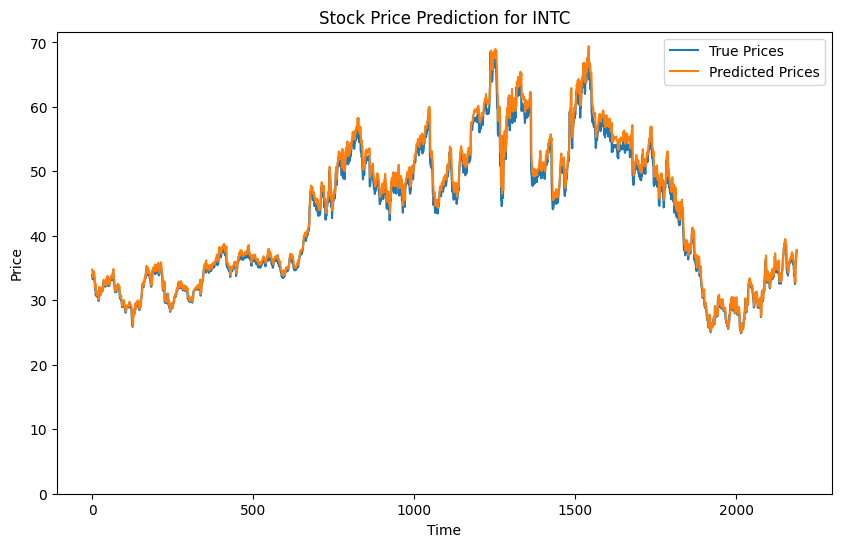

338/338 [==============================] - 12s 34ms/step


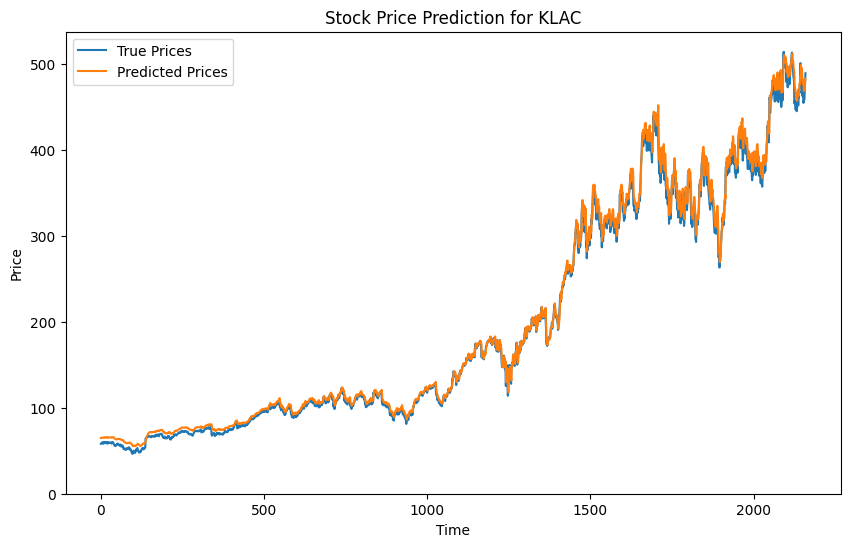

331/331 [==============================] - 12s 35ms/step


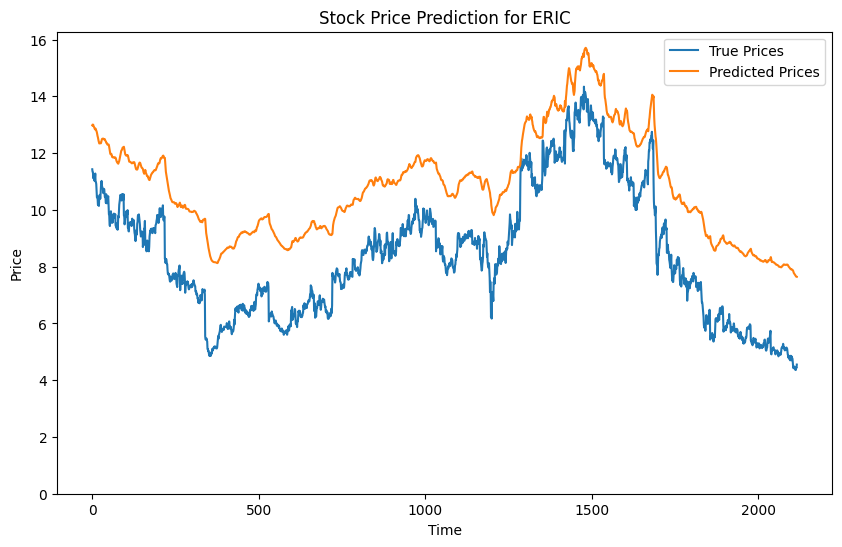

310/310 [==============================] - 11s 36ms/step


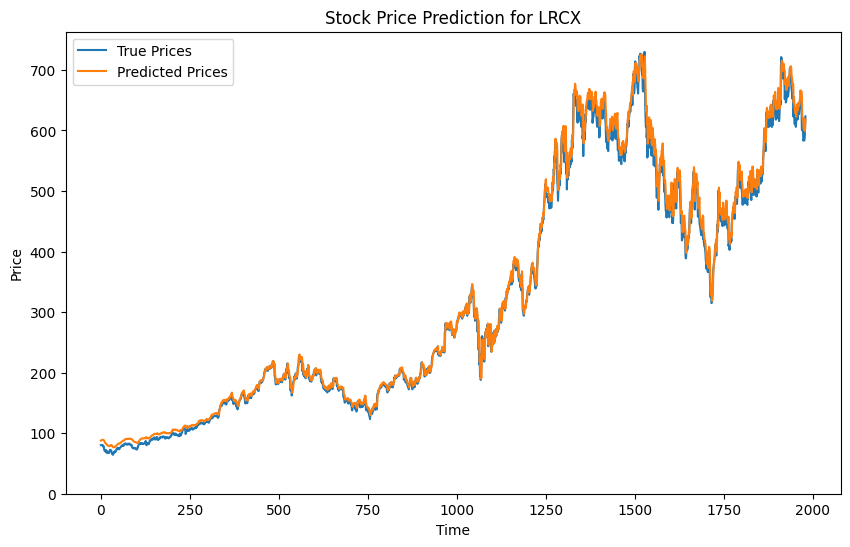

In [25]:
# Generate predictions and plot for top tickers
top_tickers = df['Ticker'].value_counts().head(10).index

# Define the function to get the number of test samples for each ticker
def get_test_samples_per_ticker(ticker, X, y):
    _, X_test_ticker, _, y_test_ticker = train_test_split(X, y, test_size=0.2, random_state=42)
    return len(y_test_ticker)

# Plotting function remains the same
def plot_predictions(ticker, true_values, predicted_values):
    plt.figure(figsize=(10, 6))
    plt.plot(true_values, label='True Prices')
    plt.plot(predicted_values, label='Predicted Prices')
    plt.title(f"Stock Price Prediction for {ticker}")
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.ylim(bottom=0)  # Set the lower y-limit to 0
    plt.legend()
    plt.show()

# Predict and plot for each of the top tickers
for ticker in top_tickers:
    ticker_data = df[df['Ticker'] == ticker]['Close'].values.reshape(-1, 1)
    scaled_data = scalers[ticker].transform(ticker_data)
    X, y = create_time_series(scaled_data, n_steps)

    if X.shape[0] > 0:
        X = X.reshape((X.shape[0], X.shape[1], 1))
        predicted_scaled = model.predict(X)

        # Calculate the number of test samples for the current ticker
        test_samples = get_test_samples_per_ticker(ticker, X, y)

        true_values = scalers[ticker].inverse_transform(y.reshape(-1, 1)).flatten()
        predicted_values = scalers[ticker].inverse_transform(predicted_scaled).flatten()

        # Plot only for the validation period
        val_period = range(len(true_values) - test_samples, len(true_values))
        plot_predictions(ticker, true_values[val_period], predicted_values[val_period])



Now let's see how cumulative predictions built upon each other work:

1/1 [==============================] - 0s 36ms/step


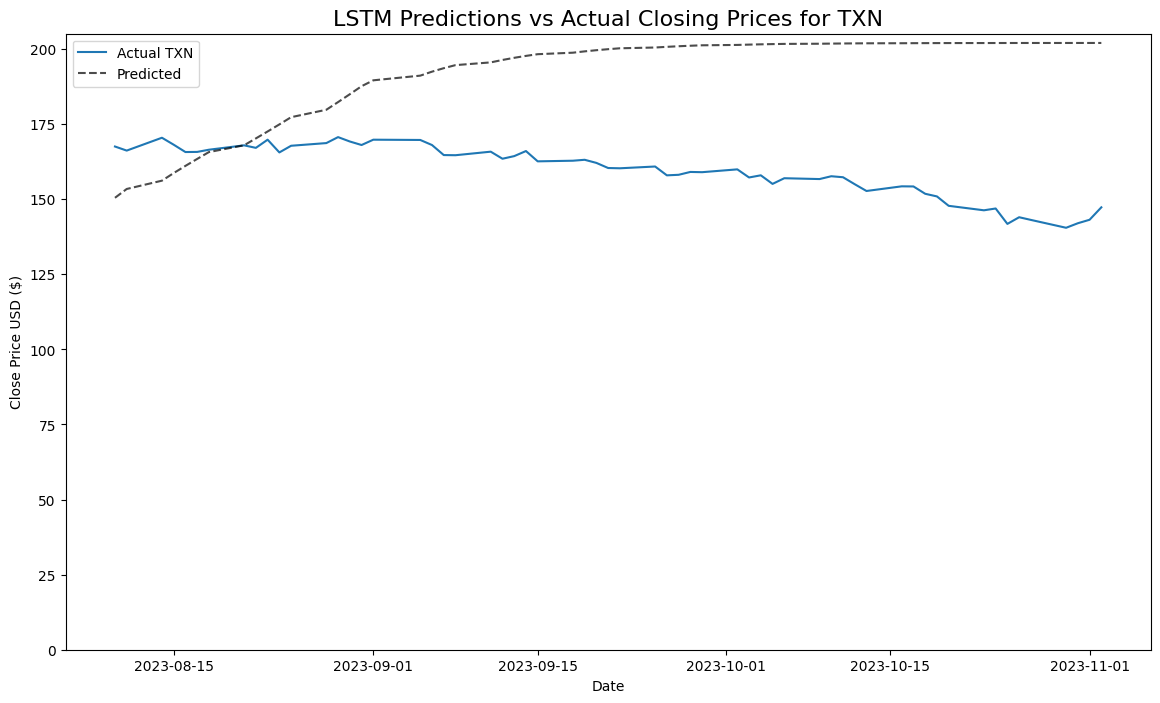

1/1 [==============================] - 0s 36ms/step


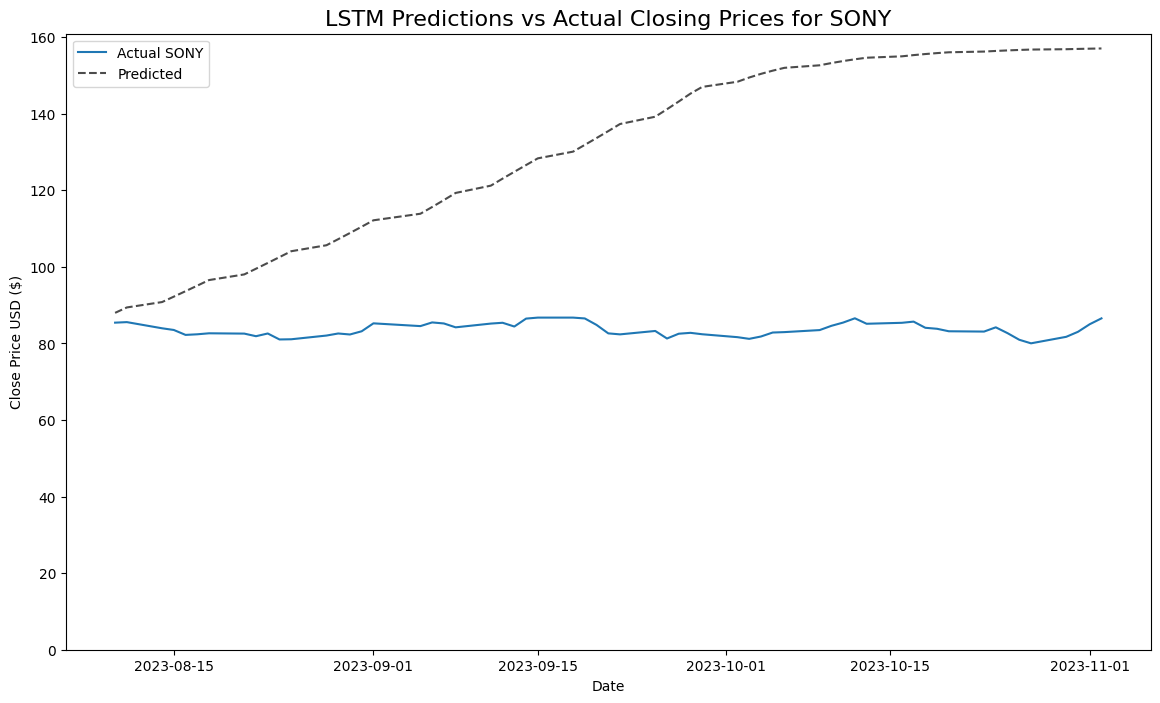

1/1 [==============================] - 0s 42ms/step


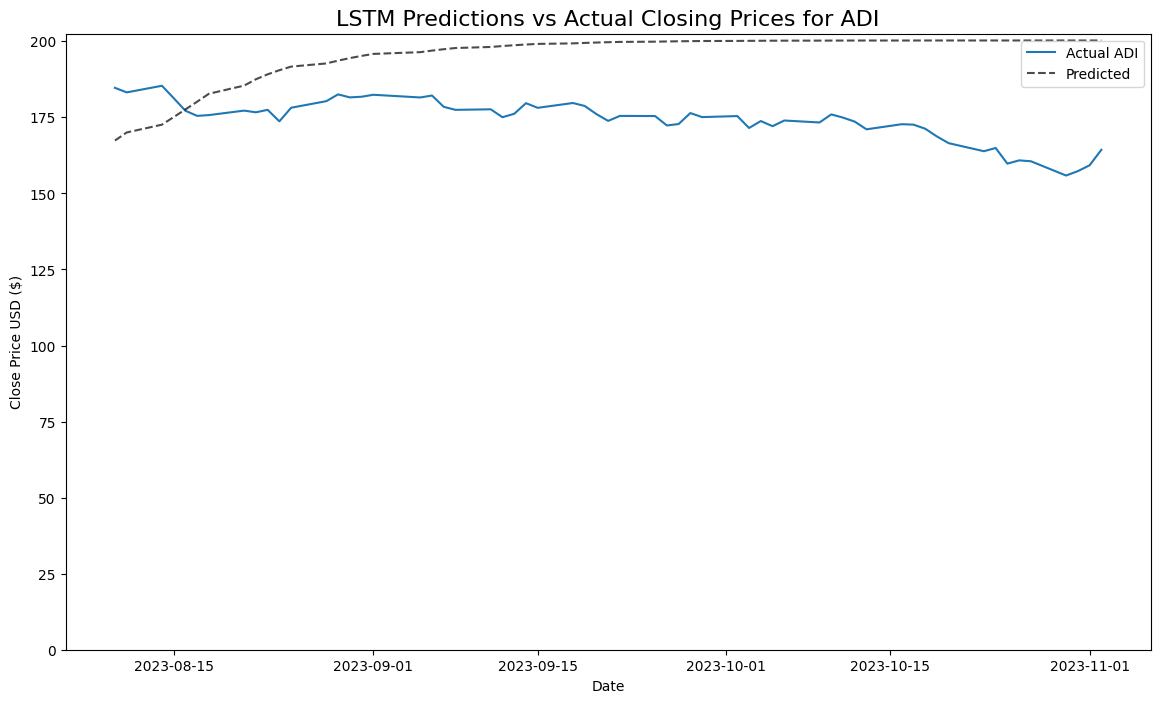

1/1 [==============================] - 0s 36ms/step


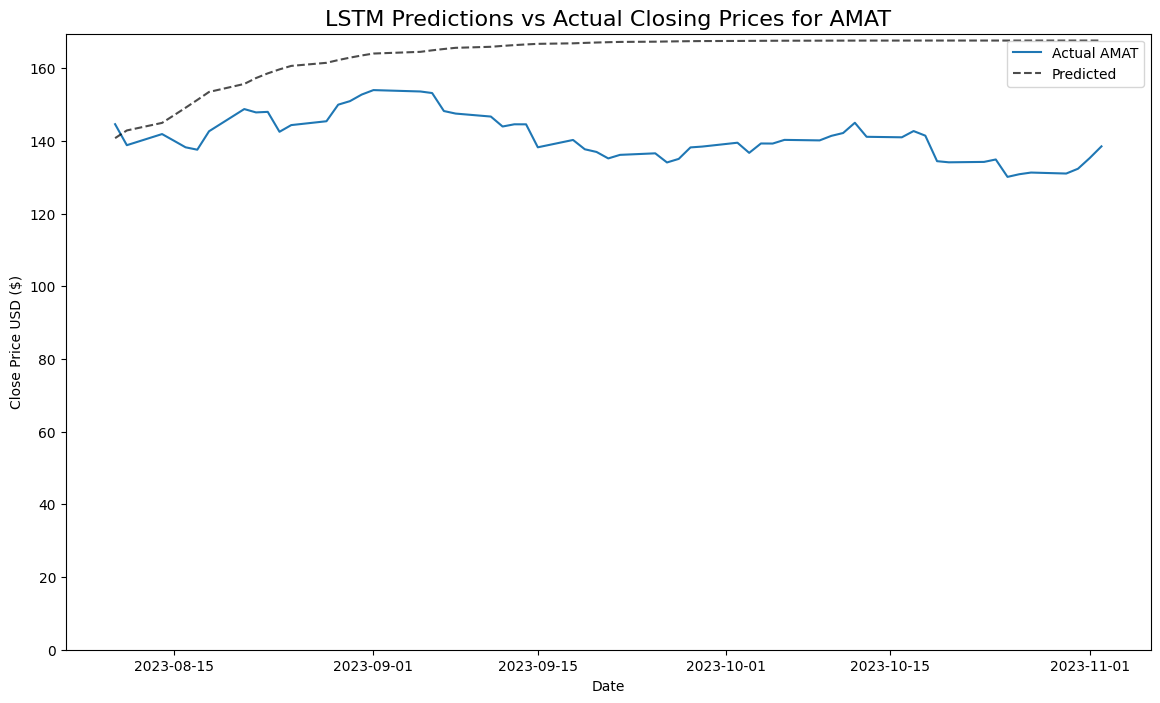

1/1 [==============================] - 0s 35ms/step


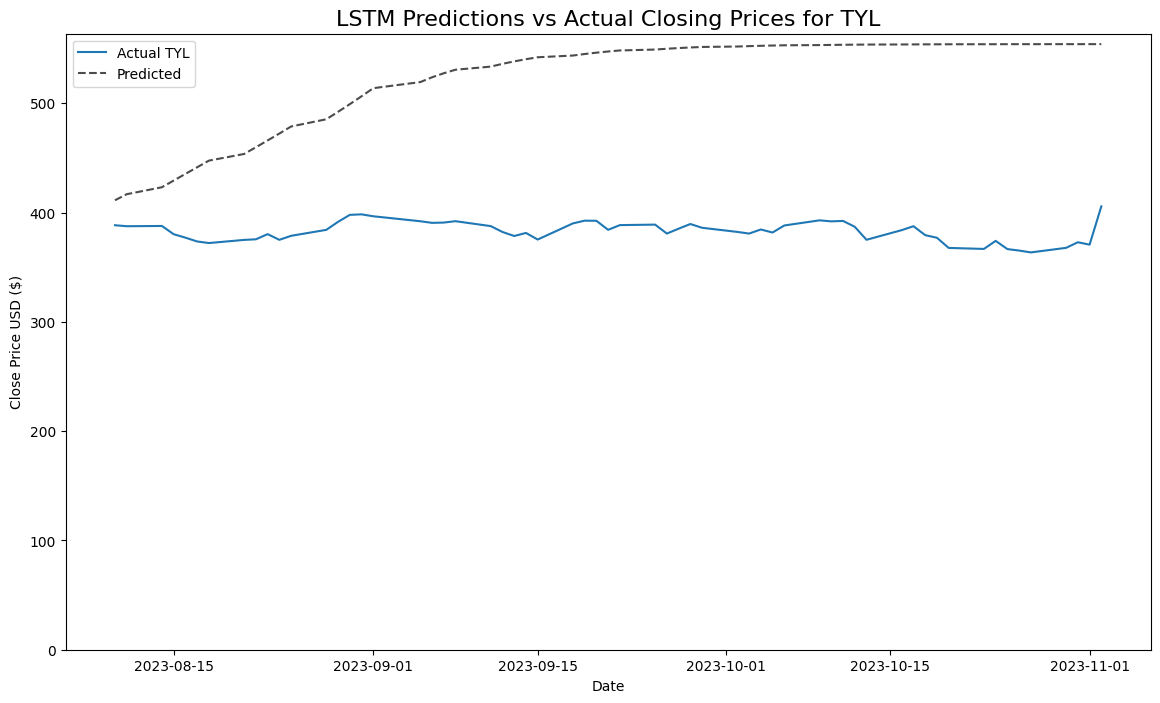

1/1 [==============================] - 0s 36ms/step


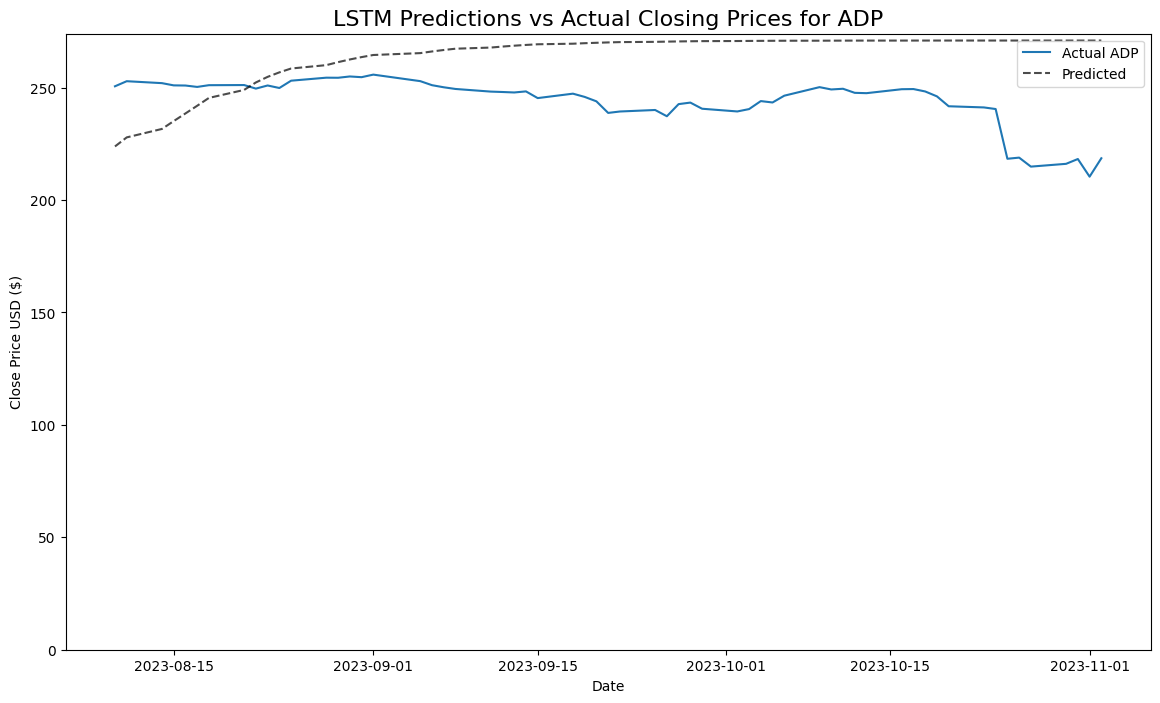

1/1 [==============================] - 0s 35ms/step


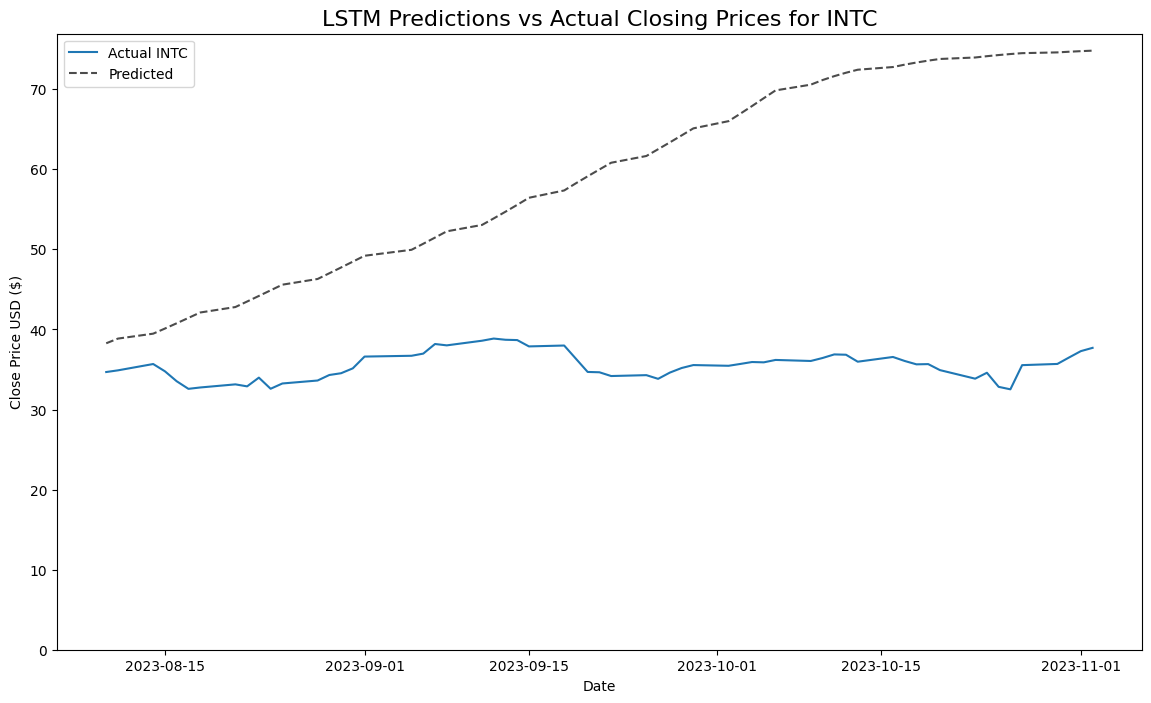

1/1 [==============================] - 0s 35ms/step


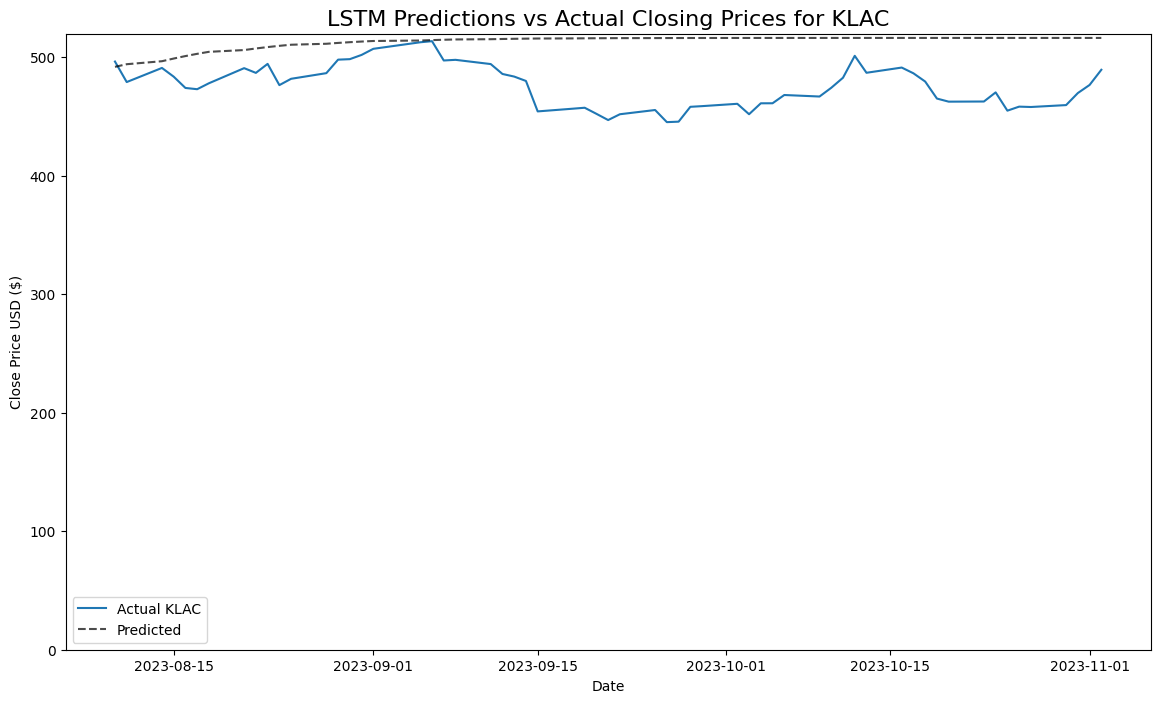

1/1 [==============================] - 0s 43ms/step


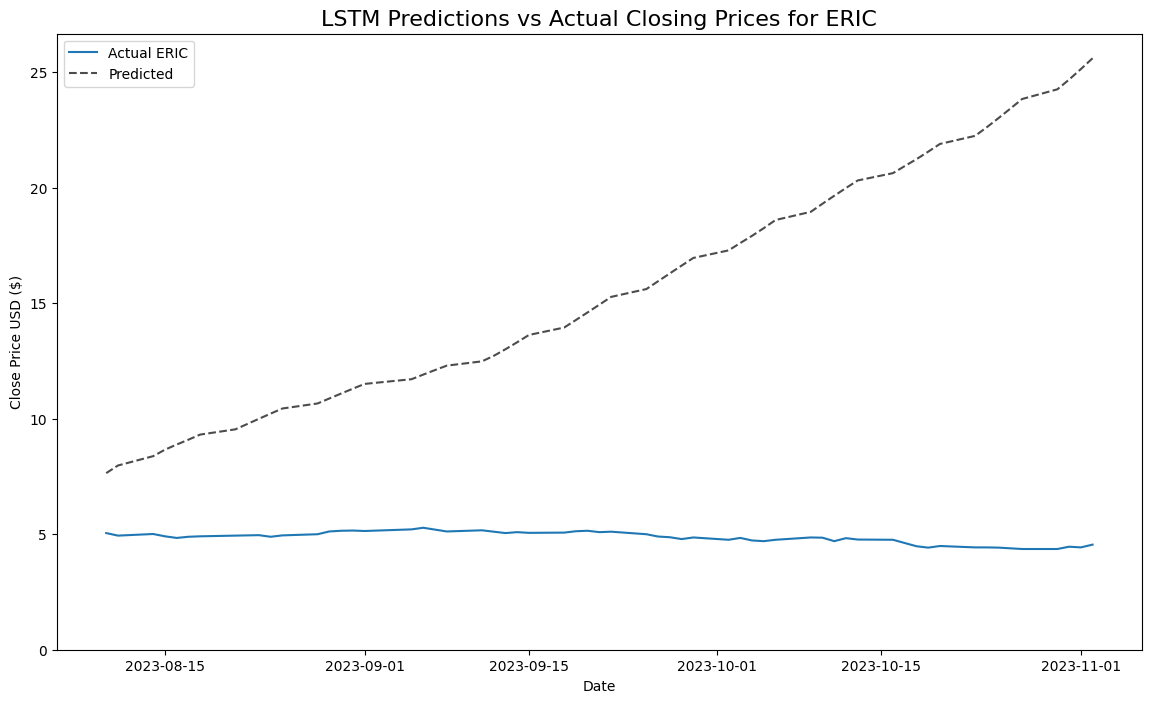

1/1 [==============================] - 0s 35ms/step


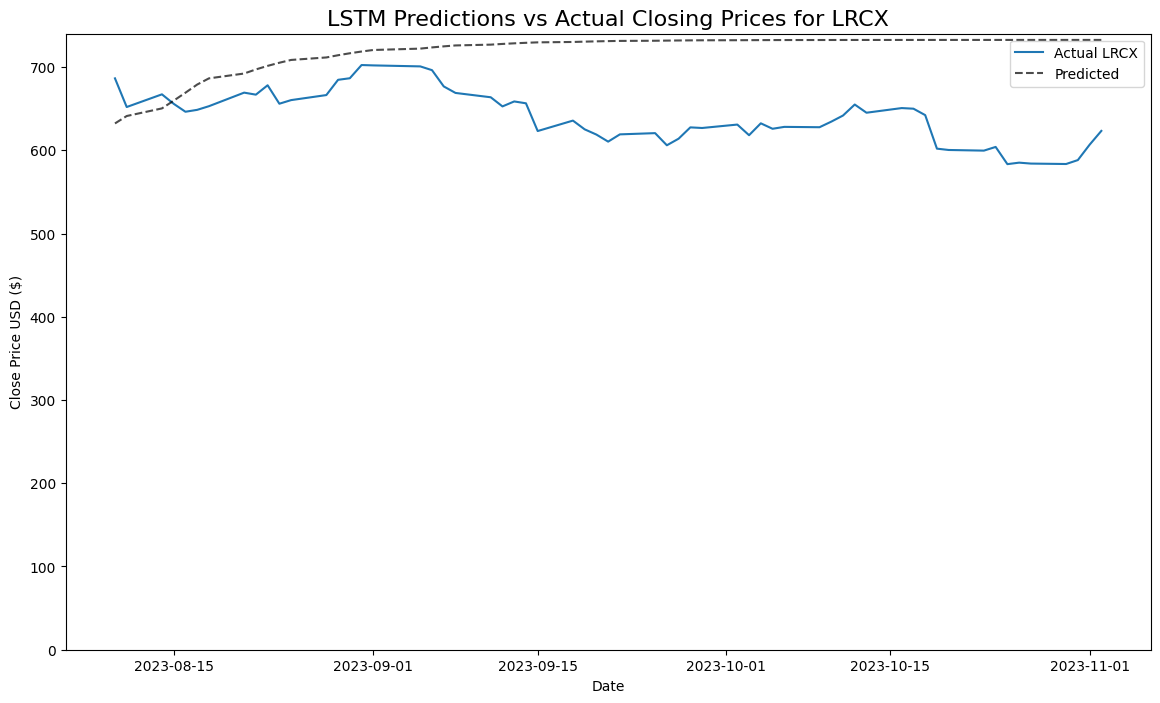

In [26]:
# Predict sequence function using the CNN model
def predict_sequence(input_sequence, model, n_steps, scaler):
    result = []
    input_data = input_sequence.copy()
    for _ in range(n_steps):
        scaled_prediction = model.predict(input_data[-X_train.shape[1]:].reshape(1, -1, 1))[0, 0]
        prediction = scaler.inverse_transform([[scaled_prediction]])[0][0]
        result.append(prediction)
        input_data = np.append(input_data[1:], scaled_prediction)  # Append scaled value
    return result


# Generate predictions and plot for top tickers
top_tickers = df['Ticker'].value_counts().head(10).index

for ticker in top_tickers:
    ticker_data = df[df['Ticker'] == ticker]
    last_prices = ticker_data['Close'].values[-X_train.shape[1]:]
    scaler = scalers[ticker]
    last_prices_scaled = scaler.transform(last_prices.reshape(-1, 1)).flatten()
    predicted_prices_scaled = predict_sequence(last_prices_scaled, model, X_train.shape[1], scaler)
    actual_dates = ticker_data['Date'].values[-X_train.shape[1]:]
    predicted_prices = np.array(predicted_prices_scaled)
    plt.figure(figsize=(14, 8))
    plt.title(f"LSTM Predictions vs Actual Closing Prices for {ticker}", size=16)
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(actual_dates, last_prices, label=f'Actual {ticker}')
    plt.plot(actual_dates, predicted_prices, 'k--', label='Predicted', alpha=0.7)
    plt.ylim(bottom=0)  # Set the lower y-limit to 0
    plt.legend()
    plt.show()

## Saving/Loading LSTM

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 3190

In [15]:
model.save('lstm.keras')  # TensorFlow 2.x uses the SavedModel format by default

In [16]:
from tensorflow.keras.models import load_model

# Create LSTM model
# model = Sequential([
#     LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
#     Dropout(0.2),
#     LSTM(50),
#     Dropout(0.2),
#     Dense(25, activation='relu'),
#     Dense(1)
# ])

model = load_model('lstm.keras')